<a href="https://colab.research.google.com/github/nityanandkore/6156-ML-Final-Project/blob/main/Final_Project_04_NK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style='color:green'>Modeling Airline Flight Delays</span>

In [ ]:
# import libraries
import os
from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import Ridge, LinearRegression, Lasso, RidgeCV, LassoCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
import statsmodels.api as sm

In [ ]:
#This will allow me to avoid typing out the full file path each time I use read_csv
import os

a_path = "C:\\Users\\P2190101\\Desktop\\NK Personal\\NK Study\\UNCC\\6156 - Machine Learning\\Class\\Project"
a_folder = "Data"
a_file = "IMG_DataCollecting.jpg"
joined_path = os.path.join(a_path, a_folder, a_file)

print(joined_path)

C:\Users\P2190101\Desktop\NK Personal\NK Study\UNCC\6156 - Machine Learning\Class\Project\Data\IMG_DataCollecting.jpg


# I. Data Importing

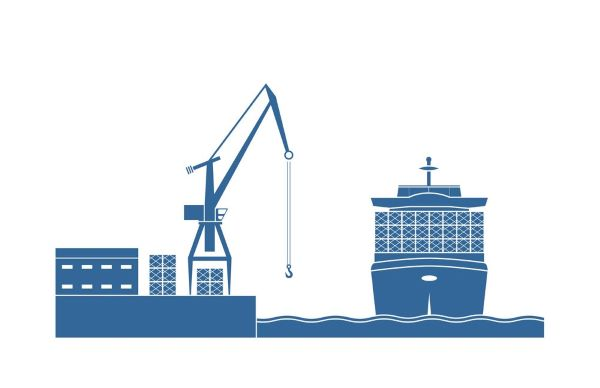

In [ ]:
from IPython import display
display.Image(joined_path)

In [ ]:
# import FAA and summary datasets
joined_path = os.path.join(a_path, a_folder, "FAA_aircraft_details.csv")
aircraft = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "airline_carrier_volume.csv")
airline_vol = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "airport_nodes_2018.csv")
airports_2018 = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "airport_nodes_2019.csv")
airports_2019 = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "edges_2018.csv")
airport_connections_2018 = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "edges_2019.csv")
airport_connections_2019 = pd.read_csv(joined_path)

joined_path = os.path.join(a_path, a_folder, "Airline_Codes.csv")
airline_codes = pd.read_csv(joined_path,encoding='latin1')


print('TABLE                    (ROWS, COLUMNS)')
print('')
print('aircraft:               ', aircraft.shape)
print('airline volume:         ', airline_vol.shape)
print('airports 2018:          ', airports_2018.shape)
print('airports 2019:          ', airports_2019.shape)
print('airport connects 2018:  ', airport_connections_2018.shape)
print('airport connects 2019:  ', airport_connections_2019.shape)
print('airline codes:          ', airline_codes.shape)

TABLE                    (ROWS, COLUMNS)

aircraft:                (6603, 55)
airline volume:          (28, 14)
airports 2018:           (371, 12)
airports 2019:           (373, 12)
airport connects 2018:   (6454, 4)
airport connects 2019:   (6658, 4)
airline codes:           (1652, 2)


### Build Dataset (based on 2019 data)

In [ ]:
# import 2019 flights (very large dataset)
joined_path = os.path.join(a_path, a_folder, "flights_all_2019.csv")
flights2019 = pd.read_csv(joined_path)

print('flights 2019 table dimensions: ', flights2019.shape)

flights 2019 table dimensions:  (8091684, 44)


In [ ]:
# Create a sample to work with until you're ready to use the entire dataset
sample2019 = flights2019.sample(n=750000, random_state=123)

print(sample2019.shape)

(750000, 44)


In [ ]:
# TO DO: Need to switch 'df' from the sample2019 table to the full table if you want to use the enture dataset


# df will reference either the full data set or the sample of that dataset. 
# This way we can simply change this cell when we are ready to switch from the sample to the full dataset.
df = sample2019
# df = flights2019

In [ ]:
# combine datasets into a single base table
# Note: airports_2018 & airport_connections_2019 were used to get airport attributes from the prior year
combo_2019 = df.merge(aircraft, 
                      on='TAIL_NUM',
                      how='left').merge(airports_2018,
                                        on=['ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR'],
                                        how='left').merge(airport_connections_2018,
                                                          on=['ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID'],
                                                          how='left').merge(airline_vol, 
                                                                            on="OP_UNIQUE_CARRIER",
                                                                            how='left')

print(combo_2019.shape)

(750000, 121)


In [ ]:
# Make a new dataframe object that is a copy of our dataset.
# This will allow us to experiment with making changes without changing the original dataset.
BASE_TABLE = combo_2019.copy()

# Create a variable to hold the number of rows in the BASE_TABLE for later reference
n = BASE_TABLE.shape[0]
print("n = ", n)

n =  750000


In [ ]:
# Some Aircraft Manufactures have more than one name in the dataset. Create consistent naming.

# print(combo_2019.groupby('MFR_Aircraft').size())
# print("")

# COMMENT OUT THIS CODE. There is already a column in the imported table called ACFT_MFR_DeDup that accomplishes this

# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('ALENIA', case=False), "MFR_Aircraft"] = "ALENIA"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('AIRBUS', case=False), "MFR_Aircraft"] = "AIRBUS"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('BOEING', case=False), "MFR_Aircraft"] = "BOEING"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('DIAMOND AIRCRAFT IND', case=False), "MFR_Aircraft"] = "DIAMOND AIRCRAFT IND"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('EMBRAER', case=False), "MFR_Aircraft"] = "EMBRAER"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('MCDONNELL DOUGLAS', case=False), "MFR_Aircraft"] = "MCDONNELL DOUGLAS"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('MOONEY', case=False), "MFR_Aircraft"] = "MOONEY"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft.astype(str).str.contains('ROBINSON HELICOPTER CO', case=False), "MFR_Aircraft"] = "ROBINSON HELICOPTER CO"
# BASE_TABLE.loc[BASE_TABLE.MFR_Aircraft == 'DOUGLAS', "MFR_Aircraft"] = "MCDONNELL DOUGLAS"

# print(BASE_TABLE.groupby('ACFT_MFR_DeDup').size())

In [ ]:
[ i for i in BASE_TABLE.columns]

['YEAR',
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'OP_CARRIER',
 'TAIL_NUM',
 'OP_CARRIER_FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
 'DEST',
 'DEST_CITY_NAME',
 'DEST_STATE_ABR',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'DUP',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'DISTANCE',
 'DISTANCE_GROUP',
 'FL_NUM_COMBO',
 'FL_NUM_COMBO_FULL',
 'ELAPSED_FROM_SCHED_DEP',
 'ELAPSE_RATIO',
 'N_Number',
 'SOURCE2',
 'SERIAL_NUMBER',
 'MFR_MDL_CODE',
 'ENG_MFR_MDL',
 'YEAR_MFR',
 'TYPE_REGISTRANT',
 'NAME',
 'STREET',
 'STREET2',
 'CITY',
 'STATE',
 'ZIP_CODE',
 'REGION',
 'COUNTY',
 'COUNTRY',
 'LAST_ACTION_DATE',
 'CERT_ISSUE_DATE',
 'CERTIFICATIO

In [ ]:
# Some Aircraft Models also need consistent naming


# COMMENT OUT THIS CODE. This was already accomplished in the base table that was imported

# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='ATR 42-500', "MODEL_Aircraft"] = "ATR42-500"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='DC-9-83 (MD-83)', "MODEL_Aircraft"] = "DC-9-83(MD-83)"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='DC-9-83', "MODEL_Aircraft"] = "DC-9-83(MD-83)"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='MD-83', "MODEL_Aircraft"] = "DC-9-83(MD-83)"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='MD 83', "MODEL_Aircraft"] = "DC-9-83(MD-83)"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='SAAB 2000', "MODEL_Aircraft"] = "2000"
# BASE_TABLE.loc[BASE_TABLE.MODEL_Aircraft=='SAAB 340B', "MODEL_Aircraft"] = "340B"

In [ ]:
# Create a column to hold the aircraft model group

BASE_TABLE['MODEL_GROUP_Aircraft'] = BASE_TABLE['MODEL_Aircraft'].astype(str)

BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('737', case=False), "MODEL_GROUP_Aircraft"] = "737"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('757', case=False), "MODEL_GROUP_Aircraft"] = "757"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('767', case=False), "MODEL_GROUP_Aircraft"] = "767"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('777', case=False), "MODEL_GROUP_Aircraft"] = "777"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('787', case=False), "MODEL_GROUP_Aircraft"] = "787"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('A319', case=False), "MODEL_GROUP_Aircraft"] = "A319"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('A320', case=False), "MODEL_GROUP_Aircraft"] = "A320"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('A321', case=False), "MODEL_GROUP_Aircraft"] = "A321"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('CL-600', case=False), "MODEL_GROUP_Aircraft"] = "CL-600"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('DC-9', case=False), "MODEL_GROUP_Aircraft"] = "DC-9"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('DHC-8', case=False), "MODEL_GROUP_Aircraft"] = "DHC-8"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('EMB-145', case=False), "MODEL_GROUP_Aircraft"] = "EMB-145"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('ERJ 170', case=False), "MODEL_GROUP_Aircraft"] = "ERJ 170"
BASE_TABLE.loc[BASE_TABLE.MODEL_GROUP_Aircraft.astype(str).str.contains('ERJ 190', case=False), "MODEL_GROUP_Aircraft"] = "ERJ 190"

print("10 most common aircraft model groups:")
print(BASE_TABLE.groupby('MODEL_GROUP_Aircraft').size().sort_values(ascending=False)[0:10])

10 most common aircraft model groups:
MODEL_GROUP_Aircraft
737        227607
CL-600     136823
ERJ 170     81542
A320        68417
A321        48713
EMB-145     44567
A319        39147
717-200     20108
757         16934
ERJ 190     12977
dtype: int64


In [ ]:
# Some engine manufacturers need consistent naming

# print(BASE_TABLE.MFR_Engine.value_counts())
# print("")

BASE_TABLE.loc[BASE_TABLE.MFR_Engine.astype(str).str.contains('CFM INTL', case=False), "MFR_Engine"] = "CFM INTL"
BASE_TABLE.loc[BASE_TABLE.MFR_Engine.astype(str).str.contains('P & W', case=False), "MFR_Engine"] = "P&W"
BASE_TABLE.loc[BASE_TABLE.MFR_Engine.astype(str).str.contains('P&W CANADA', case=False), "MFR_Engine"] = "P&W"
BASE_TABLE.loc[BASE_TABLE.MFR_Engine.astype(str).str.contains('ROLLS', case=False), "MFR_Engine"] = "ROLLS-ROYC"

print(BASE_TABLE.MFR_Engine.value_counts())

CFM INTL      290989
GE            229162
IAE            86858
ROLLS-ROYC     66106
P&W            35978
ALLISON        14330
AMA/EXPR        2400
LYCOMING         447
IVCHENKO         122
ROTAX             60
CONT MOTOR        53
THIELERT          16
HONEYWELL          7
AEROSPORT          5
Name: MFR_Engine, dtype: int64


In [ ]:
# Export the combined base table to csv

# This has been done. Commenting out below code to avoid accidental overwrite. 

# joined_path = os.path.join(a_path, a_folder, "COMBINED_TABLE_2019.csv")
# BASE_TABLE.to_csv(joined_path, index=False)

________________________________________________________________________________

# II. Data Exploration

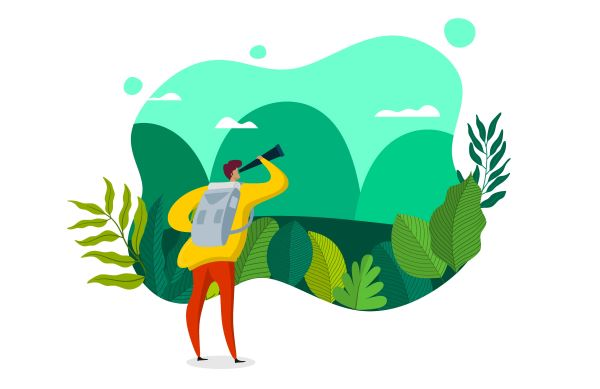

In [ ]:
display.Image(os.path.join(a_path, a_folder, "IMG_Explorer.jpg"))

In [ ]:
# If opening a new session with this notebook, you can import the combo dataset instead of running the above code.
# Note: Importing the full dataset takes a very long time. It's better to just run the code above.
# To import, uncomment the lines of code below:

# joined_path = os.path.join(a_path, a_folder, "COMBINED_TABLE_2018.csv")
# BASE_TABLE = pd.read_csv(joined_path, low_memory=False)

In [ ]:
# Create a working copy of the BASE_TABLE to make further transformations to
basecopy = BASE_TABLE.copy()

In [ ]:
# Target Variable Source Column: DEP_DELAY

# Potention Predictor Variable Source Columns:

# QUARTER     
# MONTH     
# DAY_OF_MONTH     
# DAY_OF_WEEK     
# OP_CARRIER     
# ORIGIN     
# ORIGIN_CITY_NAME (ignore)   
# ORIGIN_STATE_ABR (ignore)
# DEST             (ignore)
# DEST_CITY_NAME   (ignore)
# DEST_STATE_ABR   (ignore)
# CRS_DEP_TIME                    (numeric)
# DISTANCE                        (numeric)
# DISTANCE_GROUP
# YEAR_MFR                        (numeric)
# TYPE_AIRCRAFT
# TYPE_ENGINE
# NO_ENG                          (numeric)
# NO_SEATS                        (numeric)
# AC_WEIGHT
# MFR_Engine
# THRUST
# ACFT_MFR_DeDup
# ENGREF_MATCHES                  (as a filtering column if engine columns are significant)
# annual_departure_count          (numeric)
# median_monthly_dep_cnt          (numeric)
# mean_monthly_dep_cnt            (numeric)
# airline_count                   (numeric)
# annual_number_of_flights_btwn   (numeric)
# distance_btwn                   (numeric)
# ACTIVE_AIRCRAFT_CNT_2018        (numeric)   
# ANNUAL_FLT_CNT_2018             (numeric)
# ANNUAL_AIR_MILES_2018           (numeric)
# MODEL_GROUP_Aircraft

In [ ]:
# *************** MAKE BINARY TARGET COLUMNS ***************

# Create a binary versions of the target variable
basecopy["DEP_DELAY_GE15"] = (basecopy["DEP_DELAY"]>=15).astype(int)
basecopy["DEP_DELAY_GE30"] = (basecopy["DEP_DELAY"]>=30).astype(int)
basecopy["DEP_DELAY_GE45"] = (basecopy["DEP_DELAY"]>=45).astype(int)
basecopy["DEP_DELAY_GE60"] = (basecopy["DEP_DELAY"]>=60).astype(int)

# Also create a version of the target column that is in hours instead of minutes
basecopy["DEP_DELAY_HR"] = round(basecopy["DEP_DELAY"]/60, 2)


# Confirm that the new columns look correct:
# print(basecopy.loc[basecopy.DEP_DELAY>-10,
#                    ["DEP_DELAY_HR", "DEP_DELAY", "DEP_DELAY_GE30", "DEP_DELAY_GE45", "DEP_DELAY_GE60"]].head(10))

In [ ]:
#basecopy.to_csv(joined_path, index=False)

In [ ]:
np.random.uniform(size=basecopy.shape[0])

array([0.91541006, 0.8460509 , 0.86692129, ..., 0.18432394, 0.86113469,
       0.20145734])

In [ ]:
# *************** TRAIN/TEST SPLIT ***************

# Keep 60% for training, 20% for validation, and 20% for backtesting after model is completed.
# We are doing this at the beginning of the analysis phase so that any insights we use are for the training set only.
np.random.seed(123)
basecopy["randuni"]=np.random.uniform(size=basecopy.shape[0])

training = basecopy[basecopy.randuni<=0.60].copy()
validation = basecopy[(basecopy.randuni>0.60) & (basecopy.randuni<=0.80)].copy()
backtest = basecopy[basecopy.randuni>0.80].copy()

print("training pct:   ", 100*training.shape[0]/n , "%")
print("validation pct: ", 100*validation.shape[0]/n , "%")
print("backtest pct:   ", 100*backtest.shape[0]/n , "%")
print("")
print(training.shape[0], " + ", validation.shape[0], " + ", backtest.shape[0], " = ",
      training.shape[0] + validation.shape[0] + backtest.shape[0])
print("")
print("Confirm that the percent delayed is similar for all three datasets:")
print("training delay rate:   ", round(100*training[training.DEP_DELAY>=30].shape[0]/training.shape[0], 1), "%")
print("validation delay rate: ", round(100*validation[validation.DEP_DELAY>=30].shape[0]/validation.shape[0], 1), "%")
print("backtest delay rate:   ", round(100*backtest[backtest.DEP_DELAY>=30].shape[0]/backtest.shape[0], 1), "%")

training pct:    60.032266666666665 %
validation pct:  19.9944 %
backtest pct:    19.973333333333333 %

450242  +  149958  +  149800  =  750000

Confirm that the percent delayed is similar for all three datasets:
training delay rate:    12.2 %
validation delay rate:  12.4 %
backtest delay rate:    12.2 %


#### Target Variable Exploration

In [ ]:
# Dependent Variable

# Distribution
print("DISTRIBUTION OF DEP_DELAY")
print(training["DEP_DELAY"].describe())
print("")
print("")

print("At least 15min delay row count: ", training[training.DEP_DELAY>=15].shape[0])
print("At least 15min delay row count: ", round(100*training[training.DEP_DELAY>10].shape[0]/training.shape[0], 1), "%")
print("")
print("At least 30min delay row count: ", training[training.DEP_DELAY>=30].shape[0])
print("At least 30min delay frequency: ", round(100*training[training.DEP_DELAY>=30].shape[0]/training.shape[0], 1), "%")
print("")
print("At least 45min delay row count: ", training[training.DEP_DELAY>=45].shape[0])
print("At least 45min delay frequency: ", round(100*training[training.DEP_DELAY>=45].shape[0]/training.shape[0], 1), "%")
print("")
print("At least 60min delay row count: ", training[training.DEP_DELAY>=60].shape[0])
print("At least 60min delay frequency: ", round(100*training[training.DEP_DELAY>=60].shape[0]/training.shape[0], 1), "%")

DISTRIBUTION OF DEP_DELAY
count    442022.000000
mean         11.057477
std          50.477705
min         -57.000000
25%          -6.000000
50%          -2.000000
75%           7.000000
max        1784.000000
Name: DEP_DELAY, dtype: float64


At least 15min delay row count:  83061
At least 15min delay row count:  21.2 %

At least 30min delay row count:  54873
At least 30min delay frequency:  12.2 %

At least 45min delay row count:  39806
At least 45min delay frequency:  8.8 %

At least 60min delay row count:  30084
At least 60min delay frequency:  6.7 %


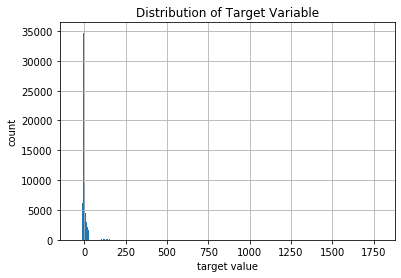

In [ ]:
# Plot a histogram of target distribution
training["DEP_DELAY"].hist(bins='auto')
plt.title("Distribution of Target Variable")
plt.xlabel("target value")
plt.ylabel("count")
print("")

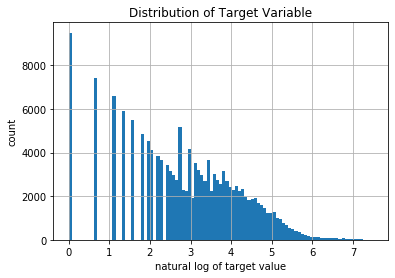

In [ ]:
np.log(training[training.DEP_DELAY>0]["DEP_DELAY"]).hist(bins='auto')
plt.title("Distribution of Target Variable")
plt.xlabel("natural log of target value")
plt.ylabel("count")
print("")

#### Numeric Predictor Exploration

In [ ]:
# CRS_DEP_TIME
# The last two digits of the departure time are the minutes. 

print("Min Dep Time: ", np.min(training.CRS_DEP_TIME))
print("Max Dep Time: ", np.max(training.CRS_DEP_TIME))

Min Dep Time:  1
Max Dep Time:  2359


In [ ]:
training[['DISTANCE', 'NO_SEATS', 'annual_departure_count', 'airline_count', 'annual_number_of_flights_btwn', 
          'ACTIVE_AIRCRAFT_CNT_2018', 'ANNUAL_FLT_CNT_2018', 'ANNUAL_AIR_MILES_2018']].describe()


# NOTE: Half the airports have more than 136K flights a year according to annual_departure_count 

,DISTANCE,NO_SEATS,annual_departure_count,airline_count,annual_number_of_flights_btwn,ACTIVE_AIRCRAFT_CNT_2018,ANNUAL_FLT_CNT_2018,ANNUAL_AIR_MILES_2018
count,450242.000000,445454.000000,449799.000000,449799.000000,446883.000000,450242.000000,4.502420e+05,4.502420e+05
mean,768.470714,138.142302,140340.985227,14.483845,3004.343446,522.134294,6.672963e+05,5.376954e+08
std,583.630252,75.200393,113815.747581,4.287233,2613.419134,335.525654,4.304423e+05,3.754311e+08
min,31.000000,0.000000,57.000000,1.000000,1.000000,7.000000,1.753000e+03,6.334930e+05
25%,343.000000,80.000000,47377.000000,13.000000,1206.000000,192.000000,2.460600e+05,1.279240e+08
50%,605.000000,140.000000,136989.000000,15.000000,2272.000000,487.000000,7.744010e+05,3.720942e+08
75%,1001.000000,182.000000,185312.000000,17.000000,3916.000000,764.000000,9.492830e+05,9.330943e+08
max,5095.000000,563.000000,388540.000000,21.000000,18627.000000,969.000000,1.352552e+06,1.012847e+09


In [ ]:
# Take a small random sample for faster graphing
trainingSample = training.sample(n=10000, random_state=123)

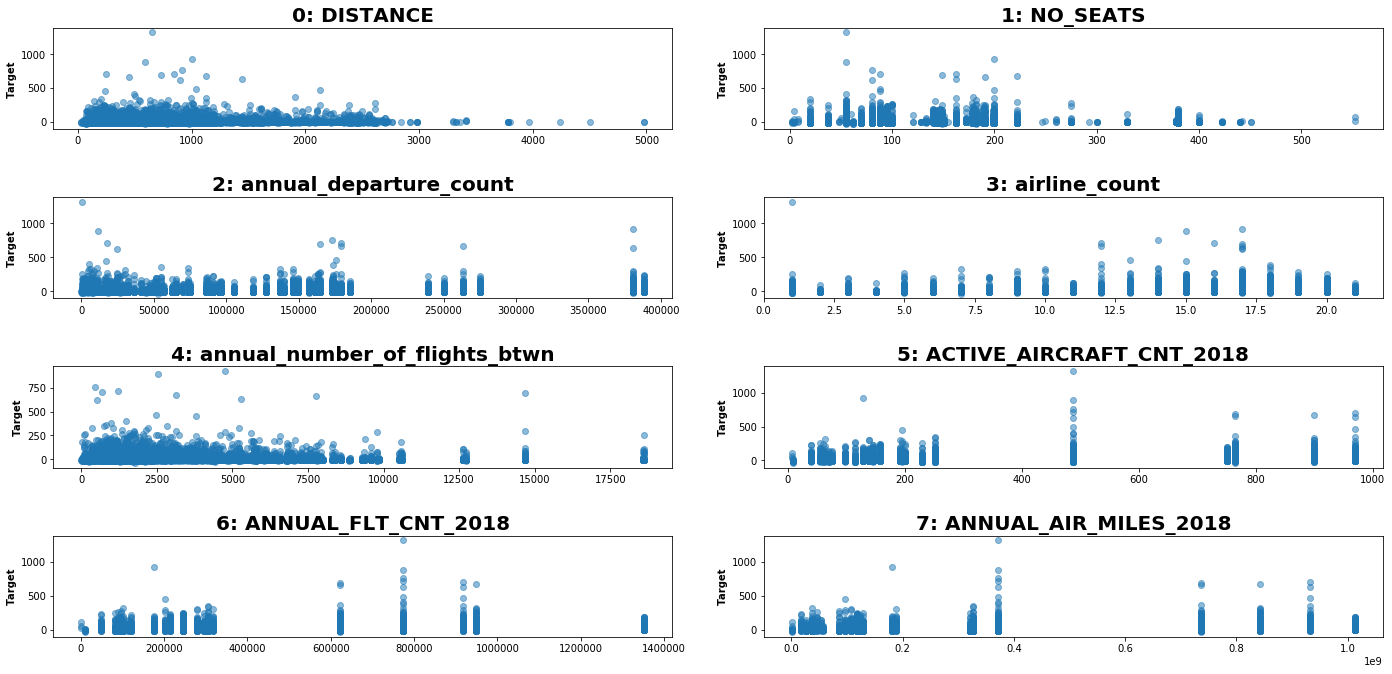

In [ ]:
# plot scatterplots of numeric variables against the target variable

numerics_X = trainingSample[['DISTANCE', 'NO_SEATS', 'annual_departure_count', 'airline_count', 
                     'annual_number_of_flights_btwn', 'ACTIVE_AIRCRAFT_CNT_2018', 'ANNUAL_FLT_CNT_2018', 
                     'ANNUAL_AIR_MILES_2018']]

numerics_y = trainingSample["DEP_DELAY"]

fig, axes = plt.subplots(4,2, figsize=(20,10))

for i, ax in enumerate(axes.ravel()):
    ax.plot(numerics_X.iloc[:,i], numerics_y, 'o', alpha=.5)
    ax.set_title("{}: {}".format(i, numerics_X.columns[i]), weight='bold', size=20)
    ax.set_ylabel("Target", weight='bold')
    
fig.tight_layout(pad=3.0)

plt.show()

RIGHT-SKEWED



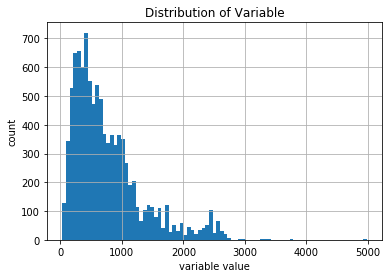

In [ ]:
print("RIGHT-SKEWED")

# Plot a histogram of different variable distributions
trainingSample["DISTANCE"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

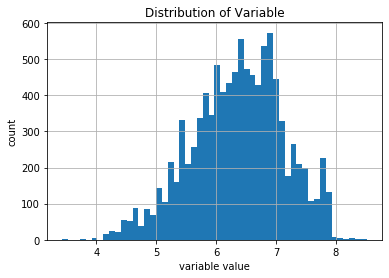

In [ ]:
np.log(trainingSample["DISTANCE"]).hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

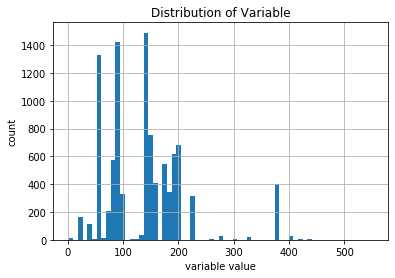

In [ ]:
trainingSample["NO_SEATS"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

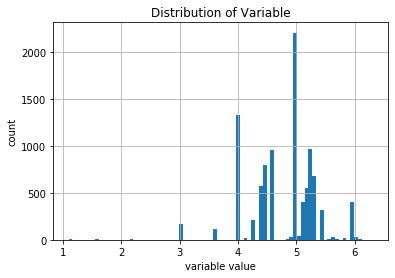

In [ ]:
np.log(trainingSample["NO_SEATS"]+1).hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

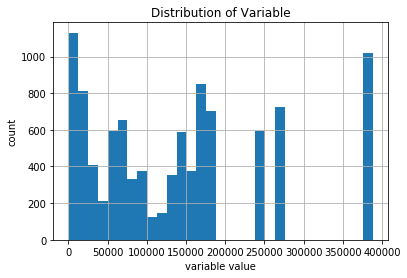

In [ ]:
trainingSample["annual_departure_count"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

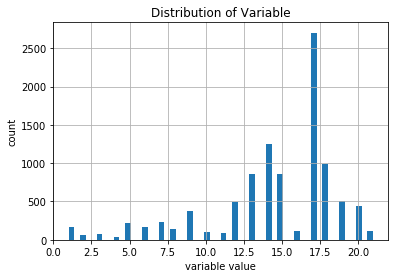

In [ ]:
trainingSample["airline_count"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

RIGHT-SKEWED



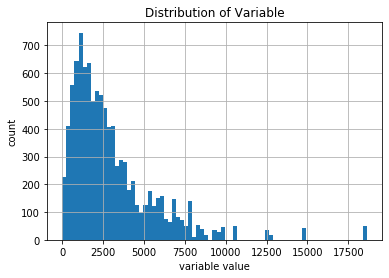

In [ ]:
print("RIGHT-SKEWED")

trainingSample["annual_number_of_flights_btwn"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

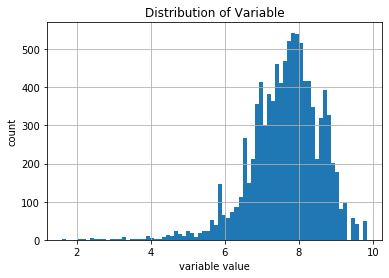

In [ ]:
np.log(trainingSample["annual_number_of_flights_btwn"]).hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

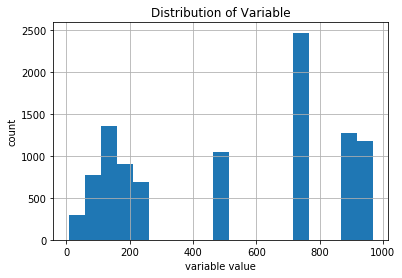

In [ ]:
trainingSample["ACTIVE_AIRCRAFT_CNT_2018"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

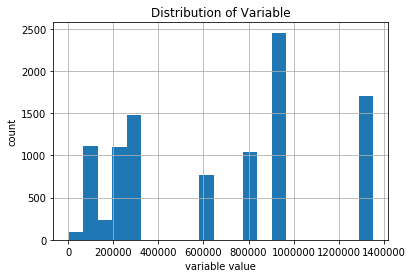

In [ ]:
trainingSample["ANNUAL_FLT_CNT_2018"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

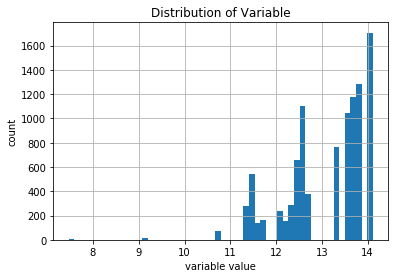

In [ ]:
np.log(trainingSample["ANNUAL_FLT_CNT_2018"]).hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

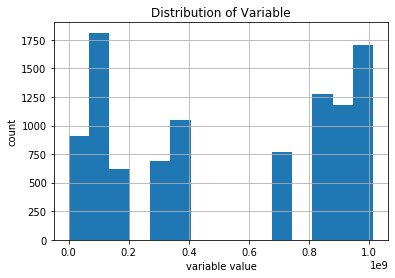

In [ ]:
trainingSample["ANNUAL_AIR_MILES_2018"].hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

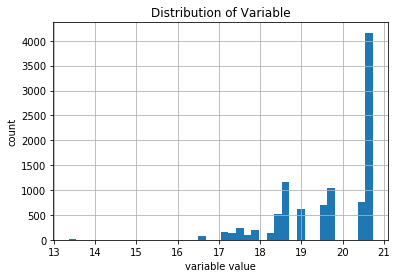

In [ ]:
np.log(trainingSample["ANNUAL_AIR_MILES_2018"]).hist(bins='auto')
plt.title("Distribution of Variable")
plt.xlabel("variable value")
plt.ylabel("count")
print("")

#### Categorical Predictor Exploration

In [ ]:
# How many rows remain if we only keep rows where ENGREF_MATCHES==True? 
print(basecopy[basecopy.ENGREF_MATCHES==True].shape)
print(basecopy[basecopy.ENGREF_MATCHES==False].shape)
print(basecopy.shape[0])
print(basecopy[basecopy.ENGREF_MATCHES==True].shape[0] + basecopy[basecopy.ENGREF_MATCHES==False].shape[0])

(654123, 128)
(70010, 128)
750000
724133


#### Use crosstab frequency tables to see if categories have higher than avg delay percentage

In [ ]:
print("VARIABLE: NO_ENG")
print("________________")
print("")
print("Value Counts:")
print(training.NO_ENG.value_counts())
print("")

cxtab = pd.crosstab(training.NO_ENG, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print("Crosstab Freqs:")
print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: This variable probably not valuable.

VARIABLE: NO_ENG
________________

Value Counts:
2.0    444935
1.0       507
3.0        10
4.0         2
Name: NO_ENG, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
NO_ENG                            
4.0             0.500000  0.500000
1.0             0.877712  0.122288
2.0             0.877841  0.122159
Total           0.877841  0.122159
3.0             1.000000  0.000000


In [ ]:
print("VARIABLE: QUARTER")
print("________________")
print("")
print("Value Counts:")
print(training.QUARTER.value_counts())
print("")

cxtab = pd.crosstab(training.QUARTER, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print("Crosstab Freqs:")
print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Variable not very informative

VARIABLE: QUARTER
________________

Value Counts:
3    116478
2    114360
4    112473
1    106931
Name: QUARTER, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
QUARTER                           
2               0.862146  0.137854
3               0.877213  0.122787
Total           0.878126  0.121874
1               0.880184  0.119816
4               0.893361  0.106639


###  <span style='color:blue'> * Potentially Useful Column Found: MONTH * </span>

In [ ]:
print("VARIABLE: MONTH")
print("________________")
print("")
print("Value Counts:")
print(training.MONTH.value_counts())
print("")

cxtab = pd.crosstab(training.MONTH, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print("Crosstab Freqs:")
print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Use this variable. Months 2,6,7 are higher than avg and 9,10,11 are lower than avg

VARIABLE: MONTH
________________

Value Counts:
7     39890
8     39838
6     38766
5     38485
3     38457
10    38102
12    37767
4     37109
9     36750
11    36604
1     36046
2     32428
Name: MONTH, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
MONTH                             
6               0.837280  0.162720
7               0.857132  0.142868
2               0.858857  0.141143
8               0.864426  0.135574
12              0.869992  0.130008
5               0.870027  0.129973
Total           0.878126  0.121874
4               0.879948  0.120052
3               0.888499  0.111501
1               0.890501  0.109499
10              0.899244  0.100756
11              0.911348  0.088652
9               0.912871  0.087129


In [ ]:
print("VARIABLE: DAY_OF_MONTH")
print("________________")
# print("")
# print("Value Counts:")
# print(training.DAY_OF_MONTH.value_counts())
print("")

cxtab = pd.crosstab(training.DAY_OF_MONTH, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print("Crosstab Freqs:")
print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: I was hoping to see some pattern like the end of the month is higher delays or something, but none exits.

VARIABLE: DAY_OF_MONTH
________________

Crosstab Freqs:
DEP_DELAY_GE30         0         1
DAY_OF_MONTH                      
18              0.854065  0.145935
20              0.854775  0.145225
1               0.856855  0.143145
11              0.859434  0.140566
30              0.860026  0.139974
19              0.862003  0.137997
21              0.862356  0.137644
2               0.867328  0.132672
22              0.871713  0.128287
12              0.871760  0.128240
10              0.874875  0.125125
17              0.874933  0.125067
8               0.875239  0.124761
23              0.875467  0.124533
31              0.876938  0.123062
Total           0.878126  0.121874
14              0.878443  0.121557
13              0.879352  0.120648
9               0.880599  0.119401
7               0.880908  0.119092
29              0.882431  0.117569
15              0.885430  0.114570
3               0.886782  0.113218
24              0.887811  0.112189
28              0.890277  0.10972

###  <span style='color:blue'> * Potentially Useful Column Found: DAY_OF_WEEK * </span>

In [ ]:
# NOTE: 1 is Monday, 7 is Sunday
print("VARIABLE: DAY_OF_WEEK")
print("________________")
print("")
print("Value Counts:")
print(training.DAY_OF_WEEK.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.DAY_OF_WEEK, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Mondays, Thursdays, and Fridays have the most airtraffic by counts, and have the highest delay percents
#             This can be used as a proxy for how busy an airport might be on a given day

VARIABLE: DAY_OF_WEEK
________________

Value Counts:
5    67213
1    66704
4    66435
2    65717
3    65005
7    64320
6    54848
Name: DAY_OF_WEEK, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
DAY_OF_WEEK                       
4               0.866637  0.133363
1               0.868599  0.131401
5               0.873521  0.126479
7               0.875637  0.124363
Total           0.878126  0.121874
3               0.884901  0.115099
2               0.888248  0.111752
6               0.892029  0.107971


###  <span style='color:blue'> * Potentially Useful Column Found: OP_CARRIER * </span>

In [ ]:
print("VARIABLE: OP_CARRIER")
print("________________")
print("")
print("Value Counts:")
print(training.OP_CARRIER.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.OP_CARRIER, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: There are some carriers with much higher and much lower than avg delay percentages. Likely useful column.
#             Will likely need to combine some categories to reduce dimensionality.

VARIABLE: OP_CARRIER
________________

Value Counts:
WN    75702
DL    55478
AA    52707
OO    46616
UA    34790
YX    18315
MQ    18047
B6    16468
OH    15979
AS    14554
9E    14340
YV    12983
NK    11317
F9     7611
EV     7520
PT     6895
QX     6732
ZW     6038
G4     5912
CP     5182
HA     4607
G7     4306
AX     4263
C5     3250
EM      537
KS       93
Name: OP_CARRIER, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
OP_CARRIER                        
C5              0.768000  0.232000
KS              0.774194  0.225806
AX              0.806943  0.193057
B6              0.817343  0.182657
F9              0.823413  0.176587
EV              0.840426  0.159574
G7              0.842778  0.157222
UA              0.859069  0.140931
YV              0.864823  0.135177
AA              0.870454  0.129546
OO              0.870753  0.129247
OH              0.873709  0.126291
NK              0.873730  0.126270
ZW              0.874296  0.125704
Total           0.878126  0

In [ ]:
# Get the avg delay for each airline
carrier_avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['OP_CARRIER',
                                                          'DEP_DELAY']].groupby(by='OP_CARRIER', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


carrier_pct_delayed = basecopy[['OP_CARRIER', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='OP_CARRIER', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})


# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
carrier_pct_delayed['PCT_DELAYED']=100*carrier_pct_delayed.DEP_DELAY_GE15/carrier_pct_delayed.TOTAL_FLIGHTS
carrier_pct_delayed['PCT_GE60']=100*carrier_pct_delayed.DEP_DELAY_GE60/carrier_pct_delayed.TOTAL_FLIGHTS
carrier_pct_delayed = carrier_pct_delayed[['OP_CARRIER', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# Merge the datasets (and bring in the airline name to replace the code)
carrier_stats = carrier_avg_delays.merge(carrier_pct_delayed).merge(airline_codes).sort_values(by=['TOTAL_FLIGHTS'])
carrier_stats = carrier_avg_delays.merge(carrier_pct_delayed).merge(airline_codes)
carrier_stats = carrier_stats.loc[carrier_stats.TOTAL_FLIGHTS>7000].reset_index().drop('index', axis=1)

carrier_stats['AIRLINE'] = carrier_stats.AIRLINE.str.split().str.get(0)
carrier_stats.loc[carrier_stats.AIRLINE=='Trans', 'AIRLINE'] = 'Trans States'
carrier_stats.loc[carrier_stats.AIRLINE=='Air', 'AIRLINE'] = 'Air WI'
carrier_stats.loc[carrier_stats.AIRLINE=='Allegiant', 'AIRLINE'] = 'Allgnt'
print(carrier_stats)

   OP_CARRIER   AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS       AIRLINE
0          9E   81.800823    16.211255   7.325518          23971      Endeavor
1          AA   68.531144    19.825768   6.992098          87699      American
2          AS   56.230669    15.761492   4.592671          24452        Alaska
3          AX   96.163690    23.738872  11.784655           7077  Trans States
4          B6   80.953348    25.226109  11.129272          27531       JetBlue
5          CP   82.856209    17.525773   6.758305           8730       Compass
6          DL   68.764263    14.295657   4.457470          91958         Delta
7          EV   93.684068    20.796140  10.100523          12435    ExpressJet
8          F9   67.550590    25.332180   9.536913          12719      Frontier
9          G4   70.298355    18.122944   6.095806           9728        Allgnt
10         G7  100.228899    20.293231  10.400110           7298         GoJet
11         HA   42.397321     8.685537   1.292491   

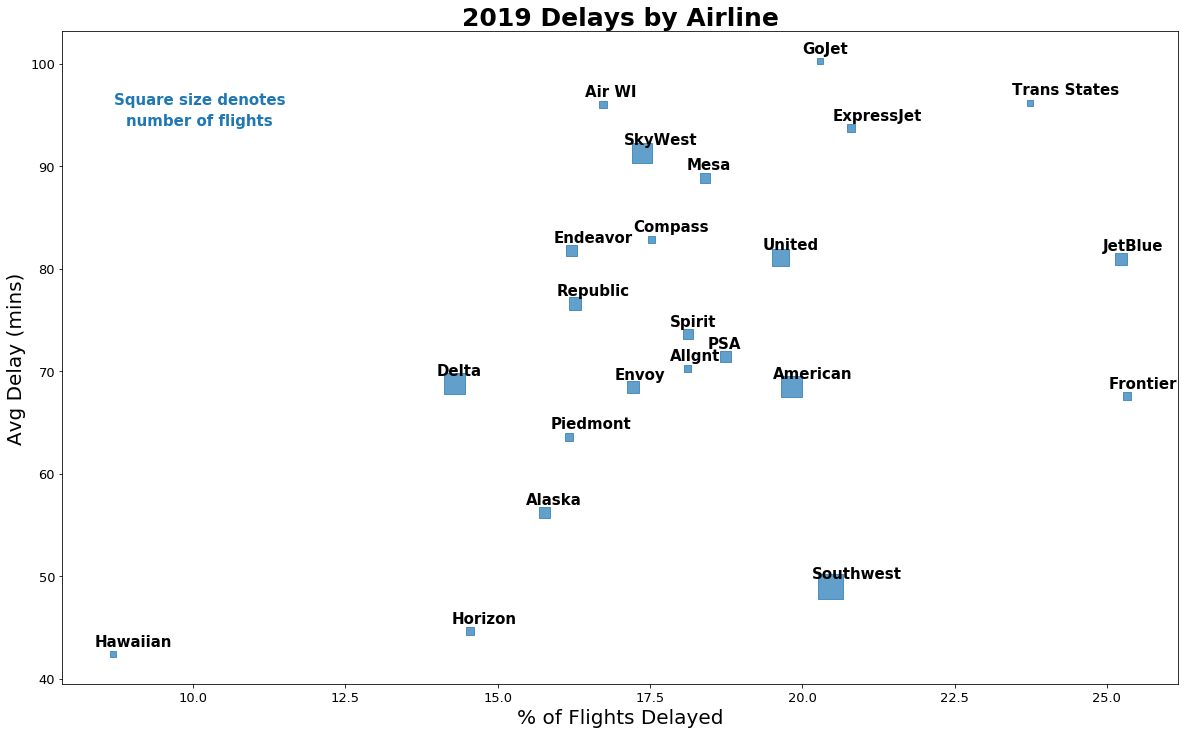

In [ ]:

# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(carrier_stats['PCT_DELAYED'], carrier_stats['AVG_DELAY'], 
           alpha=0.7, marker=",", s=carrier_stats['TOTAL_FLIGHTS']/200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('2019 Delays by Airline', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(carrier_stats['AIRLINE']):
    ax.text(carrier_stats['PCT_DELAYED'][i]-0.3, carrier_stats['AVG_DELAY'][i]+.8, label,
           weight='semibold', size=15)
ax.text(8.7, 96, 'Square size denotes ', size=15, weight='bold', color='#1f77b4')
ax.text(8.9, 94, 'number of flights ', size=15, weight='bold', color='#1f77b4')
plt.show()


# plt.figure(figsize=(20,10))
# plt.scatter(carrier_stats['PCT_DELAYED'],carrier_stats['AVG_DELAY'],
#             marker=",", s=carrier_stats['TOTAL_FLIGHTS']/200)
# plt.xlabel("X")
# plt.ylabel("Y")
# plt.title("Scatter Plot with annotations",fontsize=15)
# for i, label in enumerate(carrier_stats['AIRLINE']):
#     plt.annotate(label, (carrier_stats['PCT_DELAYED'][i], carrier_stats['AVG_DELAY'][i]))

# plt.show()

   ORIGIN  AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS
0     ATL  59.952733    16.513985   4.897550          36896
1     BNA  65.952189    19.129203   6.273348           7763
2     BOS  77.358761    21.211051   8.945100          14153
3     BWI  56.391932    20.414803   5.479870           9836
4     CLT  64.852882    18.846950   6.817702          23659
5     DAL  46.136784    23.050703   4.743644           7041
6     DCA  76.210811    18.027134   7.173375          13341
7     DEN  67.690023    22.839367   7.949179          26682
8     DFW  67.347183    21.642083   7.783899          28135
9     DTW  74.043358    15.609426   6.343444          16253
10    EWR  82.416220    26.204638  11.949475          14963
11    FLL  68.781391    22.122621   7.890660           9036
12    IAD  94.309645    15.661556   7.348098           8805
13    IAH  76.632628    19.560914   8.343831          16671
14    JFK  78.780828    18.894558   7.636054          11760
15    LAS  60.796260    19.444976   5.85

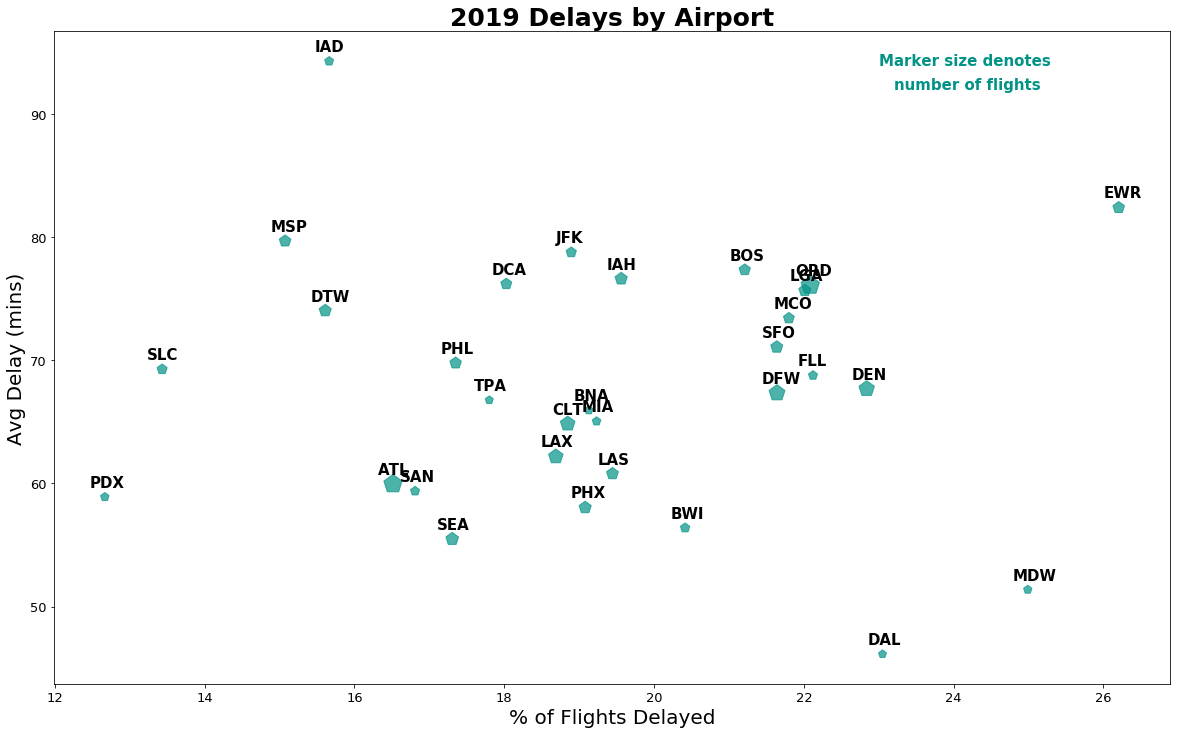

In [ ]:
# Get the avg delay for each airport
avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['ORIGIN',
                                                          'DEP_DELAY']].groupby(by='ORIGIN', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


pct_delayed = basecopy[['ORIGIN', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='ORIGIN', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})

# print(pct_delayed.sort_values(by=['TOTAL_FLIGHTS']))

# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
pct_delayed['PCT_DELAYED']=100*pct_delayed.DEP_DELAY_GE15/pct_delayed.TOTAL_FLIGHTS
pct_delayed['PCT_GE60']=100*pct_delayed.DEP_DELAY_GE60/pct_delayed.TOTAL_FLIGHTS
pct_delayed = pct_delayed[['ORIGIN', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# # Merge the datasets (and bring in the airline name to replace the code)
colm_stats = avg_delays.merge(pct_delayed).sort_values(by=['TOTAL_FLIGHTS'])
colm_stats = avg_delays.merge(pct_delayed)
colm_stats = colm_stats.loc[colm_stats.TOTAL_FLIGHTS>7000].reset_index().drop('index', axis=1)

print(colm_stats)



# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(colm_stats['PCT_DELAYED'], colm_stats['AVG_DELAY'], 
           alpha=0.7, marker="p", s=colm_stats['TOTAL_FLIGHTS']/100, color='#029386')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('2019 Delays by Airport', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(colm_stats['ORIGIN']):
    ax.text(colm_stats['PCT_DELAYED'][i]-0.2, colm_stats['AVG_DELAY'][i]+.8, label,
           weight='semibold', size=15)
ax.text(23, 94, 'Marker size denotes ', size=15, weight='bold', color='#029386')
ax.text(23.2, 92, 'number of flights ', size=15, weight='bold', color='#029386')
plt.show()

In [ ]:
print("VARIABLE: DISTANCE_GROUP")
print("________________")
print("")
print("Value Counts:")
print(training.DISTANCE_GROUP.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.DISTANCE_GROUP, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: The delay % for each group is close to the avg, so no real value here

VARIABLE: DISTANCE_GROUP
________________

Value Counts:
2     115993
3      90366
4      65701
1      65588
5      43975
6      17787
7      17406
10     10683
8       8886
11      7779
9       6078
Name: DISTANCE_GROUP, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
DISTANCE_GROUP                    
5               0.868312  0.131688
4               0.871691  0.128309
7               0.874813  0.125187
3               0.876624  0.123376
6               0.877270  0.122730
Total           0.878126  0.121874
11              0.878133  0.121867
10              0.878686  0.121314
8               0.879248  0.120752
2               0.881786  0.118214
9               0.883679  0.116321
1               0.887098  0.112902


###  <span style='color:blue'> * Potentially Useful Column Found: TYPE_AIRCRAFT * </span>

In [ ]:
print("VARIABLE: TYPE_AIRCRAFT")
print("________________")
print("")
print("Value Counts:")
print(training.TYPE_AIRCRAFT.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.TYPE_AIRCRAFT, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: There might be some benefit. Fixed wing single engine has lower delay %. 
#             But it might be a proxy for size of airport

VARIABLE: TYPE_AIRCRAFT
________________

Value Counts:
Fixed wing multi engine     444945
Fixed wing single engine       334
Rotorcraft                     175
Name: TYPE_AIRCRAFT, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30                   0         1
TYPE_AIRCRAFT                               
Fixed wing single engine  0.874251  0.125749
Total                     0.877841  0.122159
Fixed wing multi engine   0.877843  0.122157
Rotorcraft                0.880000  0.120000


###  <span style='color:blue'> * Potentially Useful Column Found: TYPE_ENGINE * </span>

In [ ]:
print("VARIABLE: TYPE_ENGINE")
print("________________")
print("")
print("Value Counts:")
print(training.TYPE_ENGINE.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.TYPE_ENGINE, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Turbo-prop has a much lower delay %

VARIABLE: TYPE_ENGINE
________________

Value Counts:
Turbo-fan        418700
Turbo-jet         21530
Turbo-prop         4719
Reciprocating       369
Turbo-shaft         134
Electric              2
Name: TYPE_ENGINE, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
TYPE_ENGINE                       
Electric        0.500000  0.500000
Reciprocating   0.867209  0.132791
Turbo-jet       0.870274  0.129726
Turbo-fan       0.877628  0.122372
Total           0.877841  0.122159
Turbo-shaft     0.888060  0.111940
Turbo-prop      0.931977  0.068023


###  <span style='color:blue'> * Potentially Useful Column Found: NO_ENG * </span>

In [ ]:
print("VARIABLE: NO_ENG")
print("________________")
print("")
print("Value Counts:")
print(training.NO_ENG.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.NO_ENG, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Might be useful. Single-Engine seems to have a lower delay %

VARIABLE: NO_ENG
________________

Value Counts:
2.0    444935
1.0       507
3.0        10
4.0         2
Name: NO_ENG, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
NO_ENG                            
4.0             0.500000  0.500000
1.0             0.877712  0.122288
2.0             0.877841  0.122159
Total           0.877841  0.122159
3.0             1.000000  0.000000


###  <span style='color:blue'> * Potentially Useful Column Found: AC_WEIGHT * </span>

In [ ]:
print("VARIABLE: AC_WEIGHT")
print("________________")
print("")
print("Value Counts:")
print(training.AC_WEIGHT.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.AC_WEIGHT, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

# CONCLUSION: Potentially useful. Look at class 4.

VARIABLE: AC_WEIGHT
________________

Value Counts:
CLASS 3    410299
CLASS 2     34626
CLASS 1       527
CLASS 4         2
Name: AC_WEIGHT, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
AC_WEIGHT                         
CLASS 4         0.500000  0.500000
CLASS 2         0.842575  0.157425
CLASS 1         0.874763  0.125237
Total           0.877841  0.122159
CLASS 3         0.880823  0.119177


###  <span style='color:blue'> * Potentially Useful Column Found: MFR_Engine * </span>

In [ ]:
print("VARIABLE: MFR_Engine")
print("________________")
print("")
print("Value Counts:")
print(training.MFR_Engine.value_counts())
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.MFR_Engine, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

VARIABLE: MFR_Engine
________________

Value Counts:
CFM INTL      174707
GE            137554
IAE            52010
ROLLS-ROYC     39851
P&W            21658
ALLISON         8544
AMA/EXPR        1412
LYCOMING         269
IVCHENKO          81
ROTAX             43
CONT MOTOR        35
THIELERT          13
HONEYWELL          4
AEROSPORT          3
Name: MFR_Engine, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30         0         1
MFR_Engine                        
CONT MOTOR      0.685714  0.314286
AMA/EXPR        0.832153  0.167847
THIELERT        0.846154  0.153846
IAE             0.856778  0.143222
ROLLS-ROYC      0.871898  0.128102
GE              0.872821  0.127179
ALLISON         0.873361  0.126639
Total           0.877990  0.122010
ROTAX           0.883721  0.116279
CFM INTL        0.886982  0.113018
LYCOMING        0.892193  0.107807
IVCHENKO        0.901235  0.098765
P&W             0.905254  0.094746
AEROSPORT       1.000000  0.000000
HONEYWELL       1.000000  0.000000


###  <span style='color:blue'> * Potentially Useful Column Found: MODEL_GROUP_Aircraft * </span>

In [ ]:
print("VARIABLE: MODEL_GROUP_Aircraft")
print("________________")
print("")
print("Value Counts:")
print(training.MODEL_GROUP_Aircraft.value_counts().head(25))
print("")


print("Crosstab Freqs:")
cxtab = pd.crosstab(training.MODEL_GROUP_Aircraft, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

VARIABLE: MODEL_GROUP_Aircraft
________________

Value Counts:
737            136558
CL-600          82310
ERJ 170         48742
A320            40989
A321            29289
EMB-145         26863
A319            23464
717-200         12160
757             10159
ERJ 190          7760
MD-88            6950
EMB-135KL        5276
nan              4788
DHC-8            4140
MD-90-30         2945
DC-9             1657
777              1347
767              1133
BD-500-1A10      1120
A330-243          756
ATR42-500         523
787               506
PA-22-150         141
407               131
8GCBC             107
Name: MODEL_GROUP_Aircraft, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30               0         1
MODEL_GROUP_Aircraft                    
DA 40                 0.000000  1.000000
SR22                  0.384615  0.615385
INSPIRE 2             0.500000  0.500000
AT-802A               0.666667  0.333333
KODIAK 100            0.666667  0.333333
MONTANA COYOTE        0.666667  0.333333
R

________________________________________________________________________________

# III. Further Preprocessing and Transformations

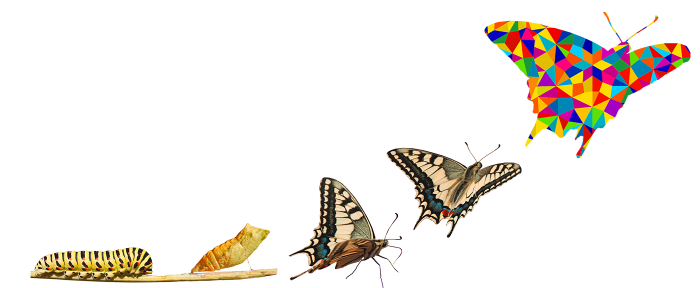

In [ ]:
display.Image(os.path.join(a_path, a_folder, "IMG_Transformation.png"))

#### Variable: ORIGIN ----> Becomes: ORIGIN_REDUCED

In [ ]:
# Which origin airports have above avg and below avg number of long delays (avg over all data is 12.2%)
large_ports = training[training.annual_departure_count>130000] # 130000 is the median annual_departure_count
print(large_ports.shape[0])
print("")

cxtab = pd.crosstab(large_ports.ORIGIN, large_ports.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab[cxtab[1]>.122].sort_values(by=1, ascending=False).head(15))

print(cxtab[cxtab[1]<.122].sort_values(by=1, ascending=True).head(15))

225638

DEP_DELAY_GE30         0         1
ORIGIN                            
EWR             0.804430  0.195570
ORD             0.841487  0.158513
LGA             0.847069  0.152931
BOS             0.847474  0.152526
SFO             0.847752  0.152248
MCO             0.851164  0.148836
DEN             0.852164  0.147836
IAH             0.857698  0.142302
DFW             0.858050  0.141950
Total           0.868192  0.131808
DCA             0.872695  0.127305
PHL             0.876028  0.123972
DEP_DELAY_GE30         0         1
ORIGIN                            
SEA             0.902027  0.097973
ATL             0.900756  0.099244
MSP             0.899235  0.100765
DTW             0.895242  0.104758
PHX             0.884992  0.115008
LAS             0.882498  0.117502
CLT             0.882108  0.117892
LAX             0.881537  0.118463


In [ ]:
# Make a column that keeps those airports that have above avg long delay rates, and convert all others to "OTHER"
basecopy["ORIGIN_REDUCED"] = basecopy["ORIGIN"]
basecopy.loc[~(basecopy["ORIGIN"].isin(['EWR', 'ORD', 'BOS', 'SFO', 'LGA', 'MCO', 'DEN', 'IAH', 'DFW', 
                                        'SEA', 'ATL', 'MSP'])), 
             "ORIGIN_REDUCED"] = "OTHER"

# Confirm that it worked
# training.loc[0:50, ["ORIGIN", "ORIGIN_REDUCED"]]
print(basecopy.ORIGIN_REDUCED.value_counts())

OTHER    496939
ORD       37445
ATL       36896
DFW       28135
DEN       26682
SEA       17885
IAH       16671
SFO       16096
LGA       15895
MSP       15066
EWR       14963
BOS       14153
MCO       13174
Name: ORIGIN_REDUCED, dtype: int64


#### Variable: OP_CARRIER  ---->  Becomes: OP_CARRIER_REDUCED

In [ ]:
print(training.OP_CARRIER.value_counts())

# Which OP_CARRIER have above avg and below avg number of long delays (avg over all data is 12.2%)
cxtab = pd.crosstab(training.OP_CARRIER, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

WN    75702
DL    55478
AA    52707
OO    46616
UA    34790
YX    18315
MQ    18047
B6    16468
OH    15979
AS    14554
9E    14340
YV    12983
NK    11317
F9     7611
EV     7520
PT     6895
QX     6732
ZW     6038
G4     5912
CP     5182
HA     4607
G7     4306
AX     4263
C5     3250
EM      537
KS       93
Name: OP_CARRIER, dtype: int64
DEP_DELAY_GE30         0         1
OP_CARRIER                        
C5              0.768000  0.232000
KS              0.774194  0.225806
AX              0.806943  0.193057
B6              0.817343  0.182657
F9              0.823413  0.176587
EV              0.840426  0.159574
G7              0.842778  0.157222
UA              0.859069  0.140931
YV              0.864823  0.135177
AA              0.870454  0.129546
OO              0.870753  0.129247
OH              0.873709  0.126291
NK              0.873730  0.126270
ZW              0.874296  0.125704
Total           0.878126  0.121874
CP              0.878811  0.121189
9E              0.881520  0

In [ ]:
# Make a column that keeps those carriers that have above avg long delay rates, and convert all others to "OTHER"
basecopy["OP_CARRIER_REDUCED"] = basecopy["OP_CARRIER"]
basecopy.loc[~(basecopy["OP_CARRIER"].isin(['C5', 'KS', 'AX', 'B6', 'F9', 'EV', 'G7', 'UA', 
                                            'AS', 'EM', 'DL', 'QX', 'HA', 
                                            'WN', 'DL', 'AA', '00', 'YX', 'MQ', 'OH', '9E', 'YV', 'NK'])), 
             "OP_CARRIER_REDUCED"] = "OTHER"

# Confirm that it worked
# training.loc[0:50, ["OP_CARRIER", "OP_CARRIER_REDUCED"]]
print(basecopy.OP_CARRIER_REDUCED.value_counts())

WN       126200
OTHER    117378
DL        91958
AA        87699
UA        58059
YX        30700
MQ        30073
B6        27531
OH        26746
AS        24452
9E        23971
YV        21406
NK        18999
F9        12719
EV        12435
QX        11202
HA         7737
G7         7298
AX         7077
C5         5370
EM          848
KS          142
Name: OP_CARRIER_REDUCED, dtype: int64


#### Variable: ACFT_MFR_DeDup ----> Becomes: ACFT_MFR_REDUCED

In [ ]:
basecopy.ACFT_MFR_DeDup.value_counts()

BOEING                            270943
AIRBUS                            158335
EMBRAER                           147944
BOMBARDIER INC                    143504
MCDONNELL DOUGLAS                  17944
C SERIES AIRCRAFT LTD PTNRSP        1273
ALENIA                               822
PIPER                                220
BELL HELICOPTER TEXTRON CANADA       219
AMERICAN CHAMPION AIRCRAFT           192
CANADAIR                             183
SAAB                                 141
CHRISTOPHER LORD                      50
CESSNA                                36
GULFSTREAM AEROSPACE                  34
CIRRUS DESIGN CORP                    30
AIR TRACTOR INC                       26
DIAMOND AIRCRAFT IND                  21
MOONEY                                17
BIGHAM JACK L                         11
SOCATA                                 9
ROBINSON HELICOPTER CO                 8
QUEST AIRCRAFT COMPANY LLC             8
DASSAULT                               7
PILATUS AIRCRAFT

In [ ]:
# Make a column that keeps most frequent Aircraft Manufacturers and groups all low-count mfctrs as "OTHER"
basecopy["ACFT_MFR_REDUCED"] = basecopy["ACFT_MFR_DeDup"]

basecopy.loc[pd.isna(basecopy["ACFT_MFR_REDUCED"]), "ACFT_MFR_REDUCED"] = "UNKNOWN"

basecopy.loc[~(basecopy["ACFT_MFR_REDUCED"].isin(['UNKNOWN', 'BOEING', 'AIRBUS', 'EMBRAER', 'BOMBARDIER INC', 
                                                'MCDONNELL DOUGLAS', 'C SERIES AIRCRAFT LTD PTNRSP', 'ALENIA',
                                                 'PIPER', 'BELL HELICOPTER TEXTRON CANADA', 'CANADAIR', 
                                                  'AMERICAN CHAMPION AIRCRAFT', 'SAAB'])), 
             "ACFT_MFR_REDUCED"] = "OTHER"

basecopy.loc[basecopy.ACFT_MFR_REDUCED=="BOMBARDIER INC", "ACFT_MFR_REDUCED"] = "BOMBARDIER"
basecopy.loc[basecopy.ACFT_MFR_REDUCED=="MCDONNELL DOUGLAS", "ACFT_MFR_REDUCED"] = "MCDONNELL"
basecopy.loc[basecopy.ACFT_MFR_REDUCED=="C SERIES AIRCRAFT LTD PTNRSP", "ACFT_MFR_REDUCED"] = "CSERIES"
basecopy.loc[basecopy.ACFT_MFR_REDUCED=="BELL HELICOPTER TEXTRON CANADA", "ACFT_MFR_REDUCED"] = "BELL"
basecopy.loc[basecopy.ACFT_MFR_REDUCED=="AMERICAN CHAMPION AIRCRAFT", "ACFT_MFR_REDUCED"] = "CHAMPION"

# Confirm that it worked
print(basecopy.ACFT_MFR_REDUCED.value_counts())
# print(training.loc[~(training["ACFT_MFR_DeDup"].isin(['BOEING', 'AIRBUS', 'EMBRAER', 'BOMBARDIER INC', 
#                                                 'MCDONNELL DOUGLAS', 'C SERIES AIRCRAFT LTD PTNRSP', 'ALENIA'])), 
#              "ACFT_MFR_REDUCED"].shape)
# print(training[training.ACFT_MFR_REDUCED=='OTHER'].shape)
# training.loc[0:50, ["ACFT_MFR_DeDup", "ACFT_MFR_REDUCED"]]

BOEING        270943
AIRBUS        158335
EMBRAER       147944
BOMBARDIER    143504
MCDONNELL      17944
UNKNOWN         7991
CSERIES         1273
ALENIA           822
OTHER            289
PIPER            220
BELL             219
CHAMPION         192
CANADAIR         183
SAAB             141
Name: ACFT_MFR_REDUCED, dtype: int64


   ACFT_MFR_REDUCED  AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS
0            AIRBUS  72.203566    20.048631   7.476553         158335
1            ALENIA  59.951220    14.963504   4.136253            822
2              BELL  49.289474    17.351598   4.566210            219
3            BOEING  58.685623    18.262882   5.270112         270943
4        BOMBARDIER  85.981951    17.876157   7.985840         143504
5          CANADAIR  77.274510    27.868852  12.568306            183
6          CHAMPION  53.593750    16.666667   3.125000            192
7           CSERIES  92.682353    26.708562  11.468971           1273
8           EMBRAER  79.557678    18.223111   7.646812         147944
9         MCDONNELL  66.593316    14.840615   4.736959          17944
10            OTHER  90.461538    26.989619  13.494810            289
11            PIPER  49.176471    15.454545   4.545455            220
12             SAAB  54.234043    33.333333  11.347518            141
13          UNKNOWN 

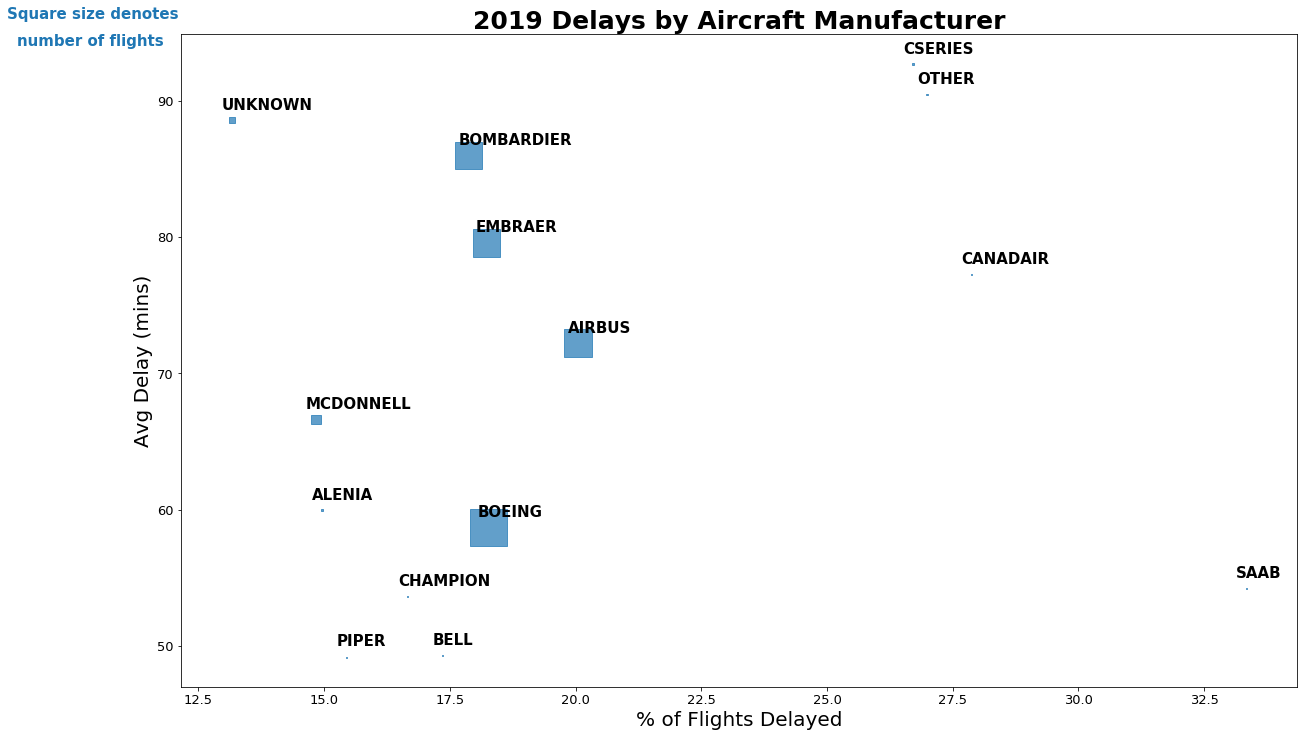

In [ ]:
# Get the avg delay for each ACFT_MFR_REDUCED
avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['ACFT_MFR_REDUCED',
                                                          'DEP_DELAY']].groupby(by='ACFT_MFR_REDUCED', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


pct_delayed = basecopy[['ACFT_MFR_REDUCED', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='ACFT_MFR_REDUCED', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})

# print(pct_delayed.sort_values(by=['TOTAL_FLIGHTS']))

# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
pct_delayed['PCT_DELAYED']=100*pct_delayed.DEP_DELAY_GE15/pct_delayed.TOTAL_FLIGHTS
pct_delayed['PCT_GE60']=100*pct_delayed.DEP_DELAY_GE60/pct_delayed.TOTAL_FLIGHTS
pct_delayed = pct_delayed[['ACFT_MFR_REDUCED', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# # Merge the datasets (and bring in the airline name to replace the code)
colm_stats = avg_delays.merge(pct_delayed).sort_values(by=['TOTAL_FLIGHTS'])
colm_stats = avg_delays.merge(pct_delayed)
# colm_stats = colm_stats.loc[colm_stats.TOTAL_FLIGHTS>7000].reset_index().drop('index', axis=1)

print(colm_stats)



# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(colm_stats['PCT_DELAYED'], colm_stats['AVG_DELAY'], 
           alpha=0.7, marker=",", s=colm_stats['TOTAL_FLIGHTS']/200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('2019 Delays by Aircraft Manufacturer', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(colm_stats['ACFT_MFR_REDUCED']):
    ax.text(colm_stats['PCT_DELAYED'][i]-0.2, colm_stats['AVG_DELAY'][i]+.8, label,
           weight='semibold', size=15)
ax.text(8.7, 96, 'Square size denotes ', size=15, weight='bold', color='#1f77b4')
ax.text(8.9, 94, 'number of flights ', size=15, weight='bold', color='#1f77b4')
plt.show()

#### Variable: MFR_Engine ----> Becomes: MFR_ENGINE_REDUCED

In [ ]:
print("MFR_Engine    Count")
print(training.MFR_Engine.value_counts())

MFR_Engine    Count
CFM INTL      174707
GE            137554
IAE            52010
ROLLS-ROYC     39851
P&W            21658
ALLISON         8544
AMA/EXPR        1412
LYCOMING         269
IVCHENKO          81
ROTAX             43
CONT MOTOR        35
THIELERT          13
HONEYWELL          4
AEROSPORT          3
Name: MFR_Engine, dtype: int64


In [ ]:
# Make a column that keeps most frequent Engine Manufacturers and groups all low-count mfctrs as "OTHER"
basecopy["MFR_ENGINE_REDUCED"] = basecopy["MFR_Engine"]

basecopy.loc[pd.isna(basecopy["MFR_ENGINE_REDUCED"]), "MFR_ENGINE_REDUCED"] = "UNKNOWN"

basecopy.loc[basecopy.MFR_ENGINE_REDUCED=="CFM INTL", "MFR_ENGINE_REDUCED"] = "CFM"
basecopy.loc[basecopy.MFR_ENGINE_REDUCED=="ROLLS-ROYC", "MFR_ENGINE_REDUCED"] = "ROLLS"
basecopy.loc[basecopy.MFR_ENGINE_REDUCED=="P&W", "MFR_ENGINE_REDUCED"] = "PW"
basecopy.loc[basecopy.MFR_ENGINE_REDUCED=="AMA/EXPR", "MFR_ENGINE_REDUCED"] = "AMA"

basecopy.loc[~(basecopy["MFR_ENGINE_REDUCED"].isin(['UNKNOWN', 'CFM', 'GE', 'IAE', 'ROLLS', 'PW', 
                                                    'ALLISON', 'AMA', 'LYCOMING'])), 
             "MFR_ENGINE_REDUCED"] = "OTHER"

# Confirm that it worked
print(basecopy.MFR_ENGINE_REDUCED.value_counts())

CFM         290989
GE          229162
IAE          86858
ROLLS        66106
PW           35978
UNKNOWN      23467
ALLISON      14330
AMA           2400
LYCOMING       447
OTHER          263
Name: MFR_ENGINE_REDUCED, dtype: int64


  MFR_ENGINE_REDUCED  AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS
0            ALLISON  71.666538    18.080949   7.229588          14330
1                AMA  72.996454    23.500000   8.416667           2400
2                CFM  58.961526    18.873566   5.536635         290989
3                 GE  83.387983    17.721088   7.699793         229162
4                IAE  74.872155    20.586474   8.118999          86858
5           LYCOMING  63.272727    17.225951   5.145414            447
6              OTHER  96.701754    21.673004  11.787072            263
7                 PW  66.070335    15.609539   4.850186          35978
8              ROLLS  82.690880    18.013493   7.601428          66106
9            UNKNOWN  78.163516    17.356288   6.877743          23467


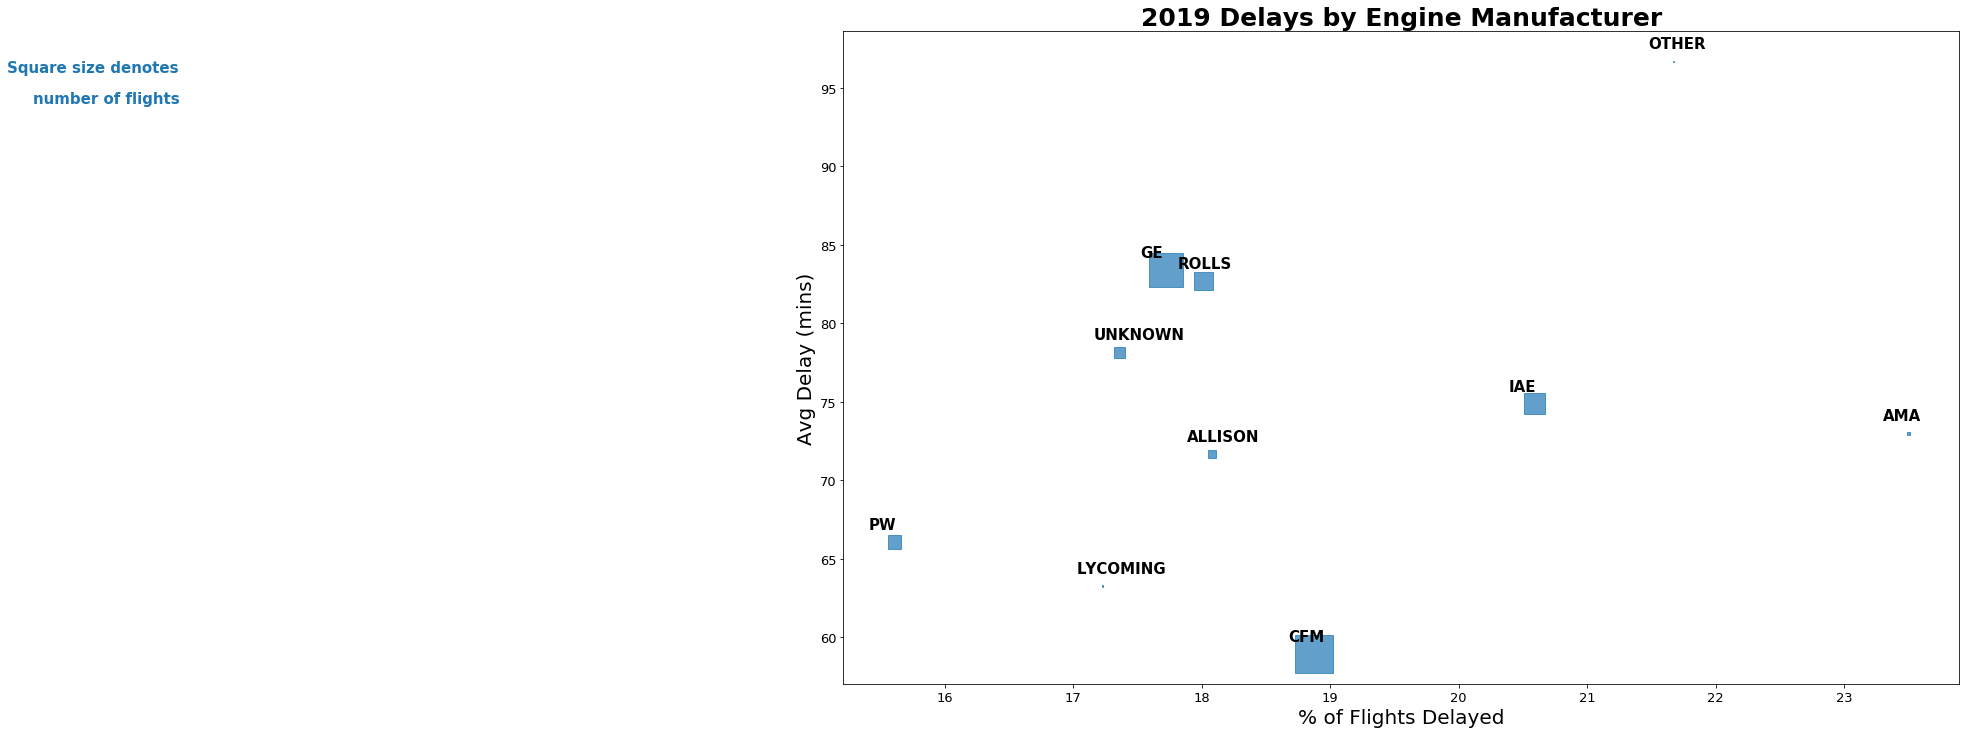

In [ ]:
# Get the avg delay for each engine manufacturer
avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['MFR_ENGINE_REDUCED',
                                                          'DEP_DELAY']].groupby(by='MFR_ENGINE_REDUCED', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


pct_delayed = basecopy[['MFR_ENGINE_REDUCED', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='MFR_ENGINE_REDUCED', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})

# print(pct_delayed.sort_values(by=['TOTAL_FLIGHTS']))

# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
pct_delayed['PCT_DELAYED']=100*pct_delayed.DEP_DELAY_GE15/pct_delayed.TOTAL_FLIGHTS
pct_delayed['PCT_GE60']=100*pct_delayed.DEP_DELAY_GE60/pct_delayed.TOTAL_FLIGHTS
pct_delayed = pct_delayed[['MFR_ENGINE_REDUCED', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# # Merge the datasets (and bring in the airline name to replace the code)
colm_stats = avg_delays.merge(pct_delayed).sort_values(by=['TOTAL_FLIGHTS'])
colm_stats = avg_delays.merge(pct_delayed)
# colm_stats = colm_stats.loc[colm_stats.TOTAL_FLIGHTS>7000].reset_index().drop('index', axis=1)

print(colm_stats)



# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(colm_stats['PCT_DELAYED'], colm_stats['AVG_DELAY'], 
           alpha=0.7, marker=",", s=colm_stats['TOTAL_FLIGHTS']/200)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('2019 Delays by Engine Manufacturer', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(colm_stats['MFR_ENGINE_REDUCED']):
    ax.text(colm_stats['PCT_DELAYED'][i]-0.2, colm_stats['AVG_DELAY'][i]+.8, label,
           weight='semibold', size=15)
ax.text(8.7, 96, 'Square size denotes ', size=15, weight='bold', color='#1f77b4')
ax.text(8.9, 94, 'number of flights ', size=15, weight='bold', color='#1f77b4')
plt.show()

#### Variable: CRS_DEP_TIME ----> Becomes: CRS_DEP_TIME_BUCKET

In [ ]:
basecopy.loc[(basecopy.CRS_DEP_TIME>=500) & (basecopy.CRS_DEP_TIME<900), "CRS_DEP_TIME_BUCKET"] = "5am-9am"
basecopy.loc[(basecopy.CRS_DEP_TIME>=900) & (basecopy.CRS_DEP_TIME<1300), "CRS_DEP_TIME_BUCKET"] = "9am-1pm"
basecopy.loc[(basecopy.CRS_DEP_TIME>=1300) & (basecopy.CRS_DEP_TIME<1700), "CRS_DEP_TIME_BUCKET"] = "1pm-5pm"
basecopy.loc[(basecopy.CRS_DEP_TIME>=1700) & (basecopy.CRS_DEP_TIME<2100), "CRS_DEP_TIME_BUCKET"] = "5pm-9pm"
basecopy.loc[~((basecopy.CRS_DEP_TIME>=500) & (basecopy.CRS_DEP_TIME<2100)), "CRS_DEP_TIME_BUCKET"] = "Redeye"

# Confirm that it worked
print(basecopy.CRS_DEP_TIME_BUCKET.value_counts())
# basecopy.loc[0:15, ["CRS_DEP_TIME", "CRS_DEP_TIME_BUCKET"]]
print("")
cxtab = pd.crosstab(basecopy.CRS_DEP_TIME_BUCKET, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')
print(cxtab.sort_values(by=1, ascending=False))

9am-1pm    183228
1pm-5pm    175048
5am-9am    172243
5pm-9pm    168482
Redeye      50999
Name: CRS_DEP_TIME_BUCKET, dtype: int64

DEP_DELAY_GE30              0         1
CRS_DEP_TIME_BUCKET                    
5pm-9pm              0.823116  0.176884
Redeye               0.841257  0.158743
1pm-5pm              0.856770  0.143230
Total                0.878126  0.121874
9am-1pm              0.899831  0.100169
5am-9am              0.941120  0.058880


  CRS_DEP_TIME_BUCKET  AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS
0             1pm-5pm  70.003771    21.812303   7.840707         175048
1             5am-9am  83.226052     9.012268   3.471259         172243
2             5pm-9pm  72.607099    25.819969  10.080009         168482
3             9am-1pm  67.562583    15.636256   5.251927         183228
4              Redeye  65.567042    24.392635   8.184474          50999


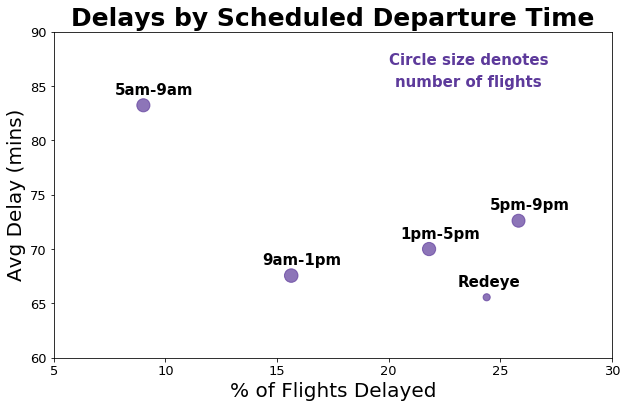

In [ ]:
# Get the avg delay for each time bucket
avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['CRS_DEP_TIME_BUCKET',
                                                          'DEP_DELAY']].groupby(by='CRS_DEP_TIME_BUCKET', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


pct_delayed = basecopy[['CRS_DEP_TIME_BUCKET', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='CRS_DEP_TIME_BUCKET', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})

# print(pct_delayed.sort_values(by=['TOTAL_FLIGHTS']))

# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
pct_delayed['PCT_DELAYED']=100*pct_delayed.DEP_DELAY_GE15/pct_delayed.TOTAL_FLIGHTS
pct_delayed['PCT_GE60']=100*pct_delayed.DEP_DELAY_GE60/pct_delayed.TOTAL_FLIGHTS
pct_delayed = pct_delayed[['CRS_DEP_TIME_BUCKET', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# # Merge the datasets (and bring in the airline name to replace the code)
colm_stats = avg_delays.merge(pct_delayed).sort_values(by=['TOTAL_FLIGHTS'])
colm_stats = avg_delays.merge(pct_delayed)
# colm_stats = colm_stats.loc[colm_stats.TOTAL_FLIGHTS>7000].reset_index().drop('index', axis=1)

print(colm_stats)



# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(colm_stats['PCT_DELAYED'], colm_stats['AVG_DELAY'], 
           alpha=0.7, marker="o", s=colm_stats['TOTAL_FLIGHTS']/1000, color="#5D3A9B")
ax.set_ylim([60, 90])
ax.set_xlim([5, 30])
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('Delays by Scheduled Departure Time', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(colm_stats['CRS_DEP_TIME_BUCKET']):
    ax.text(colm_stats['PCT_DELAYED'][i]-1.3, colm_stats['AVG_DELAY'][i]+1, label,
           weight='semibold', size=15)
ax.text(20, 87, 'Circle size denotes ', size=15, weight='bold', color='#5D3A9B')
ax.text(20.3, 85, 'number of flights ', size=15, weight='bold', color='#5D3A9B')
plt.show()

#### Variable: YEAR_MFR ----> Becomes: ACFT_AGE

In [ ]:
basecopy["ACFT_AGE"] = 2019 - basecopy.YEAR_MFR

# Confirm it worked
basecopy.loc[0:5, ["YEAR_MFR", "ACFT_AGE"]]

,YEAR_MFR,ACFT_AGE
0,2019.0,0.0
1,2007.0,12.0
2,2001.0,18.0
3,2007.0,12.0
4,2018.0,1.0
5,2004.0,15.0


#### Variable: MODEL_GROUP_Aircraft ----> Becomes: ACFT_MODEL_REDUCED

In [ ]:
print("Model    Count")
print(training.MODEL_GROUP_Aircraft.value_counts().head(25))
print("")

Model    Count
737            136558
CL-600          82310
ERJ 170         48742
A320            40989
A321            29289
EMB-145         26863
A319            23464
717-200         12160
757             10159
ERJ 190          7760
MD-88            6950
EMB-135KL        5276
nan              4788
DHC-8            4140
MD-90-30         2945
DC-9             1657
777              1347
767              1133
BD-500-1A10      1120
A330-243          756
ATR42-500         523
787               506
PA-22-150         141
407               131
8GCBC             107
Name: MODEL_GROUP_Aircraft, dtype: int64



In [ ]:
basecopy["ACFT_MODEL_REDUCED"] = basecopy["MODEL_GROUP_Aircraft"]

basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="CL-600", "ACFT_MODEL_REDUCED"] = "CL600"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="ERJ 170", "ACFT_MODEL_REDUCED"] = "ERJ170"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="EMB-145", "ACFT_MODEL_REDUCED"] = "EMB145"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="717-200", "ACFT_MODEL_REDUCED"] = "717_200"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="ERJ 190", "ACFT_MODEL_REDUCED"] = "ERJ190"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="MD-88", "ACFT_MODEL_REDUCED"] = "MD88"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="EMB-135KL", "ACFT_MODEL_REDUCED"] = "EMB135KL"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="DHC-8", "ACFT_MODEL_REDUCED"] = "DHC8"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="MD-90-30", "ACFT_MODEL_REDUCED"] = "MD90_30"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="DC-9", "ACFT_MODEL_REDUCED"] = "DC9"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="BD-500-1A10", "ACFT_MODEL_REDUCED"] = "BD500"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED.astype(str).str.contains('A330', case=False), "ACFT_MODEL_REDUCED"] = "A330"
basecopy.loc[basecopy.ACFT_MODEL_REDUCED=="ATR42-500", "ACFT_MODEL_REDUCED"] = "ATR42_500"

basecopy.loc[~(basecopy["ACFT_MODEL_REDUCED"].isin(['nan', '737', 'CL600', 'ERJ170', 'A320', 'A321', 'EMB145', 'A319',
                                                   '717_200', '757', 'ERJ190', 'MD88', 'EMB135KL', 'DHC8', 'MD90_30',
                                                   'DC9', '777', '767', 'BD500', 'A330', 'ATR42_500', '787'])), 
             "ACFT_MODEL_REDUCED"] = "OTHER"


# Confirm it work and look at crosstab freq table
print("Model    Count")
print(basecopy.ACFT_MODEL_REDUCED.value_counts())
print("")

print("Crosstab Freqs:")
cxtab = pd.crosstab(basecopy.ACFT_MODEL_REDUCED, training.DEP_DELAY_GE30, 
                               margins=True, margins_name="Total", normalize='index')

print(cxtab.sort_values(by=1, ascending=False))

Model    Count
737          227607
CL600        136823
ERJ170        81542
A320          68417
A321          48713
EMB145        44567
A319          39147
717_200       20108
757           16934
ERJ190        12977
MD88          11613
EMB135KL       8858
nan            7991
DHC8           6864
MD90_30        4932
DC9            2785
777            2246
767            1846
BD500          1835
A330           1496
OTHER          1061
ATR42_500       822
787             816
Name: ACFT_MODEL_REDUCED, dtype: int64

Crosstab Freqs:
DEP_DELAY_GE30             0         1
ACFT_MODEL_REDUCED                    
BD500               0.810714  0.189286
787                 0.816206  0.183794
ERJ190              0.828866  0.171134
DC9                 0.838865  0.161135
EMB145              0.846555  0.153445
A320                0.852033  0.147967
OTHER               0.857143  0.142857
777                 0.858203  0.141797
CL600               0.867440  0.132560
767                 0.868491  0.131509
A

   ACFT_MODEL_REDUCED  AVG_DELAY  PCT_DELAYED   PCT_GE60  TOTAL_FLIGHTS
0             717_200  73.346624    10.975731   3.635369          20108
1                 737  56.003786    18.797313   5.215130         227607
2                 757  77.192162    18.684304   7.027282          16934
3                 767  85.517426    20.205850   8.179848           1846
4                 777  79.089354    23.419412   8.192342           2246
5                 787  73.717073    25.122549  10.294118            816
6                A319  74.020855    17.393415   6.503691          39147
7                A320  74.293975    21.637897   8.473040          68417
8                A321  67.594961    19.963870   6.897543          48713
9                A330  63.547101    18.449198   4.745989           1496
10          ATR42_500  59.951220    14.963504   4.136253            822
11              BD500  95.289362    25.613079  11.444142           1835
12              CL600  87.648187    18.100758   8.267616        

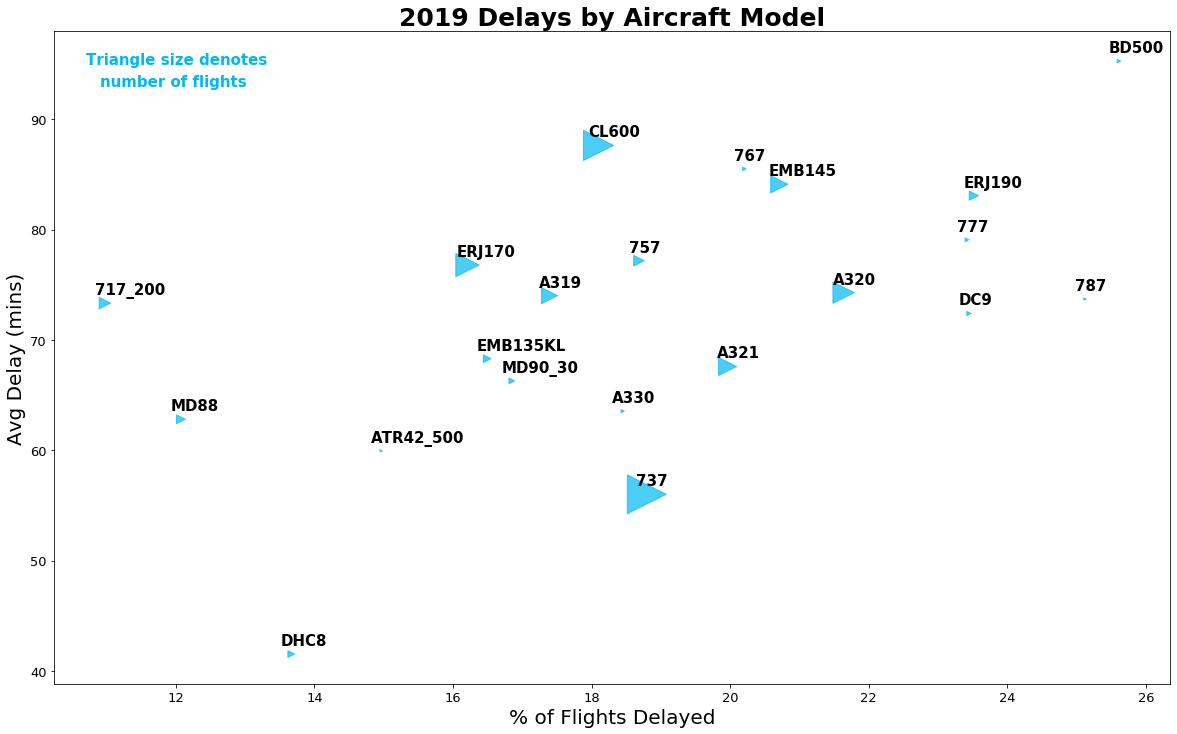

In [ ]:
# Get the avg delay for each engine manufacturer
avg_delays = basecopy.loc[basecopy.DEP_DELAY>=15, ['ACFT_MODEL_REDUCED',
                                                          'DEP_DELAY']].groupby(by='ACFT_MODEL_REDUCED', 
                                                                                as_index=False).mean().rename(columns={'DEP_DELAY':'AVG_DELAY'})


pct_delayed = basecopy[['ACFT_MODEL_REDUCED', 
                                'DEP_DELAY_GE15', 
                                'DEP_DELAY_GE60', 
                                'MONTH']].groupby(by='ACFT_MODEL_REDUCED', 
                                                  as_index=False).agg({'DEP_DELAY_GE15':'sum', 
                                                                       'DEP_DELAY_GE60':'sum',
                                                                       'MONTH':'count'}).rename(columns={'MONTH':'TOTAL_FLIGHTS'})

# print(pct_delayed.sort_values(by=['TOTAL_FLIGHTS']))

# Get the % of flights delays for each airline (as well as number of flights and % of flights delayed >=60)
pct_delayed['PCT_DELAYED']=100*pct_delayed.DEP_DELAY_GE15/pct_delayed.TOTAL_FLIGHTS
pct_delayed['PCT_GE60']=100*pct_delayed.DEP_DELAY_GE60/pct_delayed.TOTAL_FLIGHTS
pct_delayed = pct_delayed[['ACFT_MODEL_REDUCED', 'PCT_DELAYED', 'PCT_GE60', 'TOTAL_FLIGHTS']]


# Merge the datasets (and bring in the airline name to replace the code)
colm_stats = avg_delays.merge(pct_delayed).sort_values(by=['TOTAL_FLIGHTS'])
colm_stats = avg_delays.merge(pct_delayed)
colm_stats = colm_stats.loc[colm_stats.ACFT_MODEL_REDUCED != 'nan'].reset_index().drop('index', axis=1)
colm_stats = colm_stats.loc[colm_stats.ACFT_MODEL_REDUCED != 'OTHER'].reset_index().drop('index', axis=1)

print(colm_stats)



# Plot the airlines to see which ones had the worst/best delay record
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(colm_stats['PCT_DELAYED'], colm_stats['AVG_DELAY'], 
           alpha=0.7, marker=">", s=colm_stats['TOTAL_FLIGHTS']/150, color='#00B9F1')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.title('2019 Delays by Aircraft Model', weight='semibold', size=25)
plt.xlabel('% of Flights Delayed', weight='medium', size=20)
plt.ylabel('Avg Delay (mins)', weight='medium', size=20)
for i, label in enumerate(colm_stats['ACFT_MODEL_REDUCED']):
    ax.text(colm_stats['PCT_DELAYED'][i]-0.15, colm_stats['AVG_DELAY'][i]+.8, label,
           weight='semibold', size=15)
ax.text(10.7, 95, 'Triangle size denotes ', size=15, weight='bold', color='#00B9F1')
ax.text(10.9, 93, 'number of flights ', size=15, weight='bold', color='#00B9F1')
plt.show()

### Log and Polynomial Transforms

In [ ]:
basecopy["LOG_DISTANCE"]= np.log(basecopy["DISTANCE"])
basecopy[["DISTANCE", "LOG_DISTANCE"]].head(3)

,DISTANCE,LOG_DISTANCE
0,416,6.030685
1,763,6.637258
2,3784,8.238537


In [ ]:
basecopy["LOG_FLIGHTS_BTWN"]= np.log(basecopy["annual_number_of_flights_btwn"])
basecopy[["annual_number_of_flights_btwn", "LOG_FLIGHTS_BTWN"]].head(3)

,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN
0,1391.0,7.237778
1,3108.0,8.041735
2,670.0,6.507278


In [ ]:
basecopy["LOG_DEPT_COUNT"]= np.log(basecopy["annual_departure_count"])
basecopy[["annual_departure_count", "LOG_DEPT_COUNT"]].head(3)

,annual_departure_count,LOG_DEPT_COUNT
0,239305.0,12.385494
1,86736.0,11.370624
2,53051.0,10.879009


In [ ]:
basecopy["LOG_NO_SEATS"]= np.log(basecopy["NO_SEATS"]+1)
basecopy[["NO_SEATS", "LOG_NO_SEATS"]].head(3)

,NO_SEATS,LOG_NO_SEATS
0,95.0,4.564348
1,140.0,4.948760
2,440.0,6.089045


In [ ]:
print(basecopy[basecopy.ENGREF_MATCHES==True].shape)
print(basecopy[~(basecopy.ENGREF_MATCHES==True)].shape)
print(basecopy[basecopy.ENGREF_MATCHES==False].shape)
print(basecopy[pd.isnull(basecopy.ENGREF_MATCHES)].shape)

(654123, 139)
(95877, 139)
(70010, 139)
(25867, 139)


### Remove unneeded columns

"basekeep" will be the dataset we move forward with for model development

In [ ]:
print(basecopy.shape)
basekeep = basecopy.copy()

# Only keep rows where the engine info from the ENGINE table matches what is in the aircraft table.
basekeep = basekeep[basekeep.ENGREF_MATCHES==True]
print(basekeep.shape)

# This will be the dataset we move forward with for model development
basekeep = basekeep[["DEP_DELAY", "DEP_DELAY_HR", "DEP_DELAY_GE15","DEP_DELAY_GE30", "DEP_DELAY_GE45", "DEP_DELAY_GE60",
                     "MONTH", "DAY_OF_WEEK", "OP_CARRIER_REDUCED", "ORIGIN_REDUCED", "CRS_DEP_TIME_BUCKET", 
                     "DISTANCE", "LOG_DISTANCE", "ACFT_AGE", "TYPE_AIRCRAFT", "TYPE_ENGINE", "NO_ENG", 
                     "NO_SEATS", "LOG_NO_SEATS", "AC_WEIGHT", "MFR_ENGINE_REDUCED", "THRUST", 
                     "ACFT_MFR_REDUCED", "annual_departure_count", "LOG_DEPT_COUNT", "airline_count", 
                     "annual_number_of_flights_btwn", "LOG_FLIGHTS_BTWN", "ACTIVE_AIRCRAFT_CNT_2018", 
                     "ANNUAL_FLT_CNT_2018", "ANNUAL_AIR_MILES_2018", "ACFT_MODEL_REDUCED"]]

print(basekeep.shape)
print("")
print("Missing Value counts: ")
print(basekeep.isnull().sum()[basekeep.isnull().sum()>0])

(750000, 139)
(654123, 139)
(654123, 32)

Missing Value counts: 
DEP_DELAY                        9718
DEP_DELAY_HR                     9718
ACFT_AGE                         3836
annual_departure_count            753
LOG_DEPT_COUNT                    753
airline_count                     753
annual_number_of_flights_btwn    4878
LOG_FLIGHTS_BTWN                 4878
dtype: int64


### Imputation and/or Removal of null values

In [ ]:
# Looking at the data, when DEP_DELAY is missing, the flight was cancelled. So remove these records.
basekeep = basekeep[~(basekeep.DEP_DELAY.isnull())]

# Also remove records where missing annual_number_of_flights_btwn
basekeep = basekeep[~(basekeep.annual_number_of_flights_btwn.isnull())]

print(basekeep.shape)
print("")
print("Missing Value counts: ")
print(basekeep.isnull().sum()[basekeep.isnull().sum()>0])

(639598, 32)

Missing Value counts: 
ACFT_AGE    3774
dtype: int64


In [ ]:
# Impute missing aircraft age with the median age pre aircraft model

# First create a dataframe of median age for each acft model
medianages = pd.DataFrame(basekeep.groupby("ACFT_MODEL_REDUCED")["ACFT_AGE"].median())
medianages["Median_Age"] = medianages.ACFT_AGE
medianages.reset_index(inplace=True)
medianages= medianages[["ACFT_MODEL_REDUCED", "Median_Age"]]
print(medianages)

# Join that dataframe and replace missing ACFT_AGE values. The new imputed column is called ACFT_AGE_IMPUTED
basekeep = basekeep.merge(medianages, on='ACFT_MODEL_REDUCED', how='left')
basekeep["ACFT_AGE_IMPUTED"] = basekeep["ACFT_AGE"]
basekeep.loc[basekeep["ACFT_AGE_IMPUTED"].isnull(),"ACFT_AGE_IMPUTED"]=basekeep["Median_Age"]

basekeep.drop("Median_Age", axis=1, inplace=True)

   ACFT_MODEL_REDUCED  Median_Age
0             717_200        18.0
1                 737        11.0
2                 757        20.0
3                 767        19.0
4                 777        19.0
5                 787         3.0
6                A319        18.0
7                A320         8.0
8                A321         3.0
9                A330         5.5
10          ATR42_500        15.0
11              BD500         0.0
12              CL600        15.0
13               DHC8        10.0
14           EMB135KL        17.0
15             EMB145        19.0
16             ERJ170         4.0
17             ERJ190        11.0
18               MD88        27.0
19            MD90_30        23.0
20              OTHER        11.0


In [ ]:
print(basekeep.shape) 
print(basekeep[["ACFT_AGE", "ACFT_AGE_IMPUTED"]])

basekeep.drop("ACFT_AGE", axis=1, inplace=True)
print(basekeep.shape) 

(639598, 33)
        ACFT_AGE  ACFT_AGE_IMPUTED
0            0.0               0.0
1           12.0              12.0
2           18.0              18.0
3           12.0              12.0
4            1.0               1.0
...          ...               ...
639593      16.0              16.0
639594      19.0              19.0
639595      18.0              18.0
639596       NaN              11.0
639597      18.0              18.0

[639598 rows x 2 columns]
(639598, 32)


In [ ]:
# Create a polynomial feature for Age variable
basekeep["ACFT_AGE_IMPUTED_2"] = basekeep["ACFT_AGE_IMPUTED"]**2
basekeep[["ACFT_AGE_IMPUTED", "ACFT_AGE_IMPUTED_2"]].head(3)

,ACFT_AGE_IMPUTED,ACFT_AGE_IMPUTED_2
0,0.0,0.0
1,12.0,144.0
2,18.0,324.0


### Create dummy columns for categorical variables

In [ ]:
# Create dummies for categorical columns
base_dummied = pd.get_dummies(basekeep, 
                           columns=['MONTH', 'DAY_OF_WEEK', "OP_CARRIER_REDUCED", 
                                    "ORIGIN_REDUCED", "CRS_DEP_TIME_BUCKET", "TYPE_AIRCRAFT", 
                                    "TYPE_ENGINE", "NO_ENG", "AC_WEIGHT", "MFR_ENGINE_REDUCED", 
                                    "ACFT_MFR_REDUCED", "ACFT_MODEL_REDUCED"])

print(base_dummied.shape)
print(base_dummied.columns[0:100])
print(base_dummied.columns[100:119])

(639598, 136)
Index(['DEP_DELAY', 'DEP_DELAY_HR', 'DEP_DELAY_GE15', 'DEP_DELAY_GE30',
       'DEP_DELAY_GE45', 'DEP_DELAY_GE60', 'DISTANCE', 'LOG_DISTANCE',
       'NO_SEATS', 'LOG_NO_SEATS', 'THRUST', 'annual_departure_count',
       'LOG_DEPT_COUNT', 'airline_count', 'annual_number_of_flights_btwn',
       'LOG_FLIGHTS_BTWN', 'ACTIVE_AIRCRAFT_CNT_2018', 'ANNUAL_FLT_CNT_2018',
       'ANNUAL_AIR_MILES_2018', 'ACFT_AGE_IMPUTED', 'ACFT_AGE_IMPUTED_2',
       'MONTH_1', 'MONTH_2', 'MONTH_3', 'MONTH_4', 'MONTH_5', 'MONTH_6',
       'MONTH_7', 'MONTH_8', 'MONTH_9', 'MONTH_10', 'MONTH_11', 'MONTH_12',
       'DAY_OF_WEEK_1', 'DAY_OF_WEEK_2', 'DAY_OF_WEEK_3', 'DAY_OF_WEEK_4',
       'DAY_OF_WEEK_5', 'DAY_OF_WEEK_6', 'DAY_OF_WEEK_7',
       'OP_CARRIER_REDUCED_9E', 'OP_CARRIER_REDUCED_AA',
       'OP_CARRIER_REDUCED_AS', 'OP_CARRIER_REDUCED_AX',
       'OP_CARRIER_REDUCED_B6', 'OP_CARRIER_REDUCED_C5',
       'OP_CARRIER_REDUCED_DL', 'OP_CARRIER_REDUCED_EM',
       'OP_CARRIER_REDUCED_EV', 'OP

In [ ]:
base_dummied.shape

(639598, 136)

In [ ]:
len(base_dummied.DEP_DELAY)

639598

# IV. Model Building

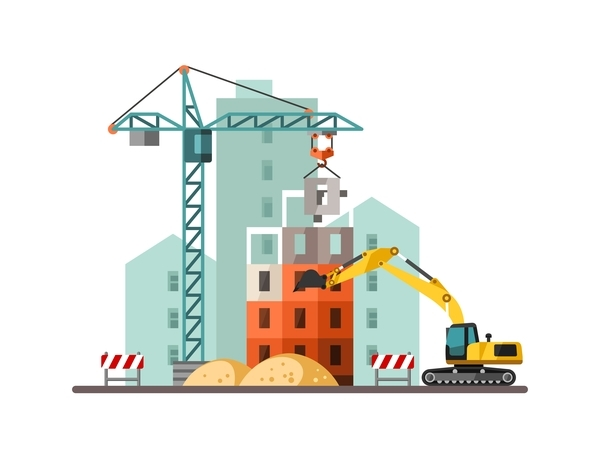

In [ ]:
display.Image(os.path.join(a_path, a_folder, "IMG_Construction.jpg"))

# PCA

________________________________________________________________________________

Find the Principle components to reduce the dimensionality
[Wicked animated GIF which illustrates PCA](http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues)

Magically, eigen-decomposition (or PCA) finds the line where
1. the spread of values along the black line is **maximal**
2. the projection error (sum of red lines) is **minimal**

<img src="https://i.stack.imgur.com/Q7HIP.gif">

In [ ]:
base_dummied.isna().sum()

DEP_DELAY                     0
DEP_DELAY_HR                  0
DEP_DELAY_GE15                0
DEP_DELAY_GE30                0
DEP_DELAY_GE45                0
                             ..
ACFT_MODEL_REDUCED_ERJ170     0
ACFT_MODEL_REDUCED_ERJ190     0
ACFT_MODEL_REDUCED_MD88       0
ACFT_MODEL_REDUCED_MD90_30    0
ACFT_MODEL_REDUCED_OTHER      0
Length: 136, dtype: int64

In [ ]:
[ i for i in base_dummied.columns]

['DEP_DELAY',
 'DEP_DELAY_HR',
 'DEP_DELAY_GE15',
 'DEP_DELAY_GE30',
 'DEP_DELAY_GE45',
 'DEP_DELAY_GE60',
 'DISTANCE',
 'LOG_DISTANCE',
 'NO_SEATS',
 'LOG_NO_SEATS',
 'THRUST',
 'annual_departure_count',
 'LOG_DEPT_COUNT',
 'airline_count',
 'annual_number_of_flights_btwn',
 'LOG_FLIGHTS_BTWN',
 'ACTIVE_AIRCRAFT_CNT_2018',
 'ANNUAL_FLT_CNT_2018',
 'ANNUAL_AIR_MILES_2018',
 'ACFT_AGE_IMPUTED',
 'ACFT_AGE_IMPUTED_2',
 'MONTH_1',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MONTH_5',
 'MONTH_6',
 'MONTH_7',
 'MONTH_8',
 'MONTH_9',
 'MONTH_10',
 'MONTH_11',
 'MONTH_12',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7',
 'OP_CARRIER_REDUCED_9E',
 'OP_CARRIER_REDUCED_AA',
 'OP_CARRIER_REDUCED_AS',
 'OP_CARRIER_REDUCED_AX',
 'OP_CARRIER_REDUCED_B6',
 'OP_CARRIER_REDUCED_C5',
 'OP_CARRIER_REDUCED_DL',
 'OP_CARRIER_REDUCED_EM',
 'OP_CARRIER_REDUCED_EV',
 'OP_CARRIER_REDUCED_F9',
 'OP_CARRIER_REDUCED_G7',
 'OP_CARRIER_REDUCED_

In [ ]:
base_dummied_final=base_dummied.drop(labels=['DEP_DELAY','DEP_DELAY_GE15','DEP_DELAY_GE30','DEP_DELAY_GE45','DEP_DELAY_GE60','DEP_DELAY_HR'], axis=1)

In [ ]:
print(base_dummied.shape)
print(base_dummied_final.shape)

(639598, 136)
(639598, 130)


In [ ]:
print(len(base_dummied))
print(len(base_dummied_final))

639598
639598


In [ ]:
base_dummied_regression_Y=base_dummied['DEP_DELAY']
base_dummied_regression_Y.shape

(639598,)

In [ ]:
len([i for i in base_dummied.DEP_DELAY])

639598

In [ ]:
len(base_dummied['DEP_DELAY'])

639598

In [ ]:
base_dummied_final.describe()

,DISTANCE,LOG_DISTANCE,NO_SEATS,LOG_NO_SEATS,THRUST,annual_departure_count,LOG_DEPT_COUNT,airline_count,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN,...,ACFT_MODEL_REDUCED_BD500,ACFT_MODEL_REDUCED_CL600,ACFT_MODEL_REDUCED_DHC8,ACFT_MODEL_REDUCED_EMB135KL,ACFT_MODEL_REDUCED_EMB145,ACFT_MODEL_REDUCED_ERJ170,ACFT_MODEL_REDUCED_ERJ190,ACFT_MODEL_REDUCED_MD88,ACFT_MODEL_REDUCED_MD90_30,ACFT_MODEL_REDUCED_OTHER
count,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.00000,639598.000000,639598.000000,...,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000,639598.000000
mean,778.714786,6.384837,139.503635,4.805934,16605.674314,139660.563384,11.311723,14.47719,3042.427303,7.646517,...,0.002212,0.199994,0.010144,0.008588,0.027685,0.121597,0.017294,0.003685,0.007272,0.001316
std,584.735097,0.767870,74.724034,0.552405,11101.531499,111600.688140,1.304431,4.24625,2649.333993,0.965402,...,0.046983,0.399996,0.100205,0.092274,0.164068,0.326820,0.130363,0.060593,0.084964,0.036259
min,31.000000,3.433987,1.000000,0.693147,0.000000,57.000000,4.043051,1.00000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,351.000000,5.860786,88.000000,4.488636,9140.000000,49178.000000,10.803202,13.00000,1209.000000,7.097549,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,612.000000,6.416732,140.000000,4.948760,14510.000000,136989.000000,11.827656,15.00000,2292.000000,7.737180,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1011.000000,6.918695,179.000000,5.192957,25000.000000,185312.000000,12.129796,17.00000,3966.000000,8.285513,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4983.000000,8.513787,563.000000,6.335054,115540.000000,388540.000000,12.870151,21.00000,18627.000000,9.832367,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
pd.set_option('display.max_rows', 5)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [ ]:
base_dummied_final.head()

,DISTANCE,LOG_DISTANCE,NO_SEATS,LOG_NO_SEATS,THRUST,annual_departure_count,LOG_DEPT_COUNT,airline_count,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN,ACTIVE_AIRCRAFT_CNT_2018,ANNUAL_FLT_CNT_2018,ANNUAL_AIR_MILES_2018,ACFT_AGE_IMPUTED,ACFT_AGE_IMPUTED_2,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_CARRIER_REDUCED_9E,OP_CARRIER_REDUCED_AA,OP_CARRIER_REDUCED_AS,OP_CARRIER_REDUCED_AX,OP_CARRIER_REDUCED_B6,OP_CARRIER_REDUCED_C5,OP_CARRIER_REDUCED_DL,OP_CARRIER_REDUCED_EM,OP_CARRIER_REDUCED_EV,OP_CARRIER_REDUCED_F9,OP_CARRIER_REDUCED_G7,OP_CARRIER_REDUCED_HA,OP_CARRIER_REDUCED_KS,OP_CARRIER_REDUCED_MQ,OP_CARRIER_REDUCED_NK,OP_CARRIER_REDUCED_OH,OP_CARRIER_REDUCED_OTHER,OP_CARRIER_REDUCED_QX,OP_CARRIER_REDUCED_UA,OP_CARRIER_REDUCED_WN,OP_CARRIER_REDUCED_YV,OP_CARRIER_REDUCED_YX,ORIGIN_REDUCED_ATL,ORIGIN_REDUCED_BOS,ORIGIN_REDUCED_DEN,ORIGIN_REDUCED_DFW,ORIGIN_REDUCED_EWR,ORIGIN_REDUCED_IAH,ORIGIN_REDUCED_LGA,ORIGIN_REDUCED_MCO,ORIGIN_REDUCED_MSP,ORIGIN_REDUCED_ORD,ORIGIN_REDUCED_OTHER,ORIGIN_REDUCED_SEA,ORIGIN_REDUCED_SFO,CRS_DEP_TIME_BUCKET_1pm-5pm,CRS_DEP_TIME_BUCKET_5am-9am,CRS_DEP_TIME_BUCKET_5pm-9pm,CRS_DEP_TIME_BUCKET_9am-1pm,CRS_DEP_TIME_BUCKET_Redeye,TYPE_AIRCRAFT_Fixed wing multi engine,TYPE_AIRCRAFT_Fixed wing single engine,TYPE_AIRCRAFT_Rotorcraft,TYPE_ENGINE_Reciprocating,TYPE_ENGINE_Turbo-fan,TYPE_ENGINE_Turbo-jet,TYPE_ENGINE_Turbo-prop,TYPE_ENGINE_Turbo-shaft,NO_ENG_1.0,NO_ENG_2.0,NO_ENG_3.0,AC_WEIGHT_CLASS 1,AC_WEIGHT_CLASS 2,AC_WEIGHT_CLASS 3,MFR_ENGINE_REDUCED_ALLISON,MFR_ENGINE_REDUCED_CFM,MFR_ENGINE_REDUCED_GE,MFR_ENGINE_REDUCED_IAE,MFR_ENGINE_REDUCED_LYCOMING,MFR_ENGINE_REDUCED_OTHER,MFR_ENGINE_REDUCED_PW,MFR_ENGINE_REDUCED_ROLLS,ACFT_MFR_REDUCED_AIRBUS,ACFT_MFR_REDUCED_ALENIA,ACFT_MFR_REDUCED_BELL,ACFT_MFR_REDUCED_BOEING,ACFT_MFR_REDUCED_BOMBARDIER,ACFT_MFR_REDUCED_CANADAIR,ACFT_MFR_REDUCED_CHAMPION,ACFT_MFR_REDUCED_CSERIES,ACFT_MFR_REDUCED_EMBRAER,ACFT_MFR_REDUCED_MCDONNELL,ACFT_MFR_REDUCED_OTHER,ACFT_MFR_REDUCED_PIPER,ACFT_MFR_REDUCED_SAAB,ACFT_MODEL_REDUCED_717_200,ACFT_MODEL_REDUCED_737,ACFT_MODEL_REDUCED_757,ACFT_MODEL_REDUCED_767,ACFT_MODEL_REDUCED_777,ACFT_MODEL_REDUCED_787,ACFT_MODEL_REDUCED_A319,ACFT_MODEL_REDUCED_A320,ACFT_MODEL_REDUCED_A321,ACFT_MODEL_REDUCED_A330,ACFT_MODEL_REDUCED_ATR42_500,ACFT_MODEL_REDUCED_BD500,ACFT_MODEL_REDUCED_CL600,ACFT_MODEL_REDUCED_DHC8,ACFT_MODEL_REDUCED_EMB135KL,ACFT_MODEL_REDUCED_EMB145,ACFT_MODEL_REDUCED_ERJ170,ACFT_MODEL_REDUCED_ERJ190,ACFT_MODEL_REDUCED_MD88,ACFT_MODEL_REDUCED_MD90_30,ACFT_MODEL_REDUCED_OTHER
0,416,6.030685,95.0,4.564348,14510.0,239305.0,12.385494,17.0,1391.0,7.237778,139,278462,106916302,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,763,6.637258,140.0,4.948760,24200.0,86736.0,11.370624,14.0,3108.0,8.041735,751,1352552,1012847097,12.0,144.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3784,8.238537,440.0,6.089045,22000.0,53051.0,10.879009,7.0,670.0,6.507278,969,916818,933094276,18.0,324.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,201,5.303305,95.0,4.564348,14510.0,173584.0,12.064417,18.0,1673.0,7.422374,158,246060,117120617,12.0,144.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
scaler_df=base_dummied_final[[
 'DISTANCE',
 'LOG_DISTANCE',
 'NO_SEATS',
 'LOG_NO_SEATS',
 'THRUST',
 'annual_departure_count',
 'LOG_DEPT_COUNT',
 'airline_count',
 'annual_number_of_flights_btwn',
 'LOG_FLIGHTS_BTWN',
 'ACTIVE_AIRCRAFT_CNT_2018',
 'ANNUAL_FLT_CNT_2018',
 'ANNUAL_AIR_MILES_2018',
 'ACFT_AGE_IMPUTED',
 'ACFT_AGE_IMPUTED_2']
 ]

In [ ]:
scaler_df.shape

(639598, 15)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_data=scaler.fit_transform(scaler_df)

In [ ]:
scaled_data_final=pd.DataFrame(data=scaled_data, columns= scaler_df.columns)

In [ ]:
scaled_data_final.describe()

,DISTANCE,LOG_DISTANCE,NO_SEATS,LOG_NO_SEATS,THRUST,annual_departure_count,LOG_DEPT_COUNT,airline_count,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN,ACTIVE_AIRCRAFT_CNT_2018,ANNUAL_FLT_CNT_2018,ANNUAL_AIR_MILES_2018,ACFT_AGE_IMPUTED,ACFT_AGE_IMPUTED_2
count,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05
mean,1.945130e-16,-1.877300e-16,-8.861208e-17,-3.175004e-15,4.190150e-16,1.372855e-15,-4.757690e-16,2.615074e-15,-9.342753e-17,6.894780e-16,-4.443777e-16,-7.899855e-16,-4.770256e-16,-1.745350e-16,-6.603794e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,3.972489e-01,6.952463e-01,5.285635e-01,7.006147e-01,7.561418e-01,4.090608e-01,6.271500e-01,5.941270e-01,3.486059e-01,6.618964e-01,7.040547e-01,5.923562e-01,1.015635e+00,8.551387e-01,7.520846e-01
max,7.190074e+00,2.772542e+00,5.667476e+00,2.768115e+00,8.911780e+00,2.230090e+00,1.194720e+00,1.536135e+00,5.882454e+00,2.264187e+00,1.324574e+00,1.522313e+00,1.228750e+00,4.581870e+00,1.022274e+01


In [ ]:
scaled_data_final.shape

(639598, 15)

In [ ]:
base_dummied_final.shape

(639598, 130)

In [ ]:
base_dummied_final.head()

,DISTANCE,LOG_DISTANCE,NO_SEATS,LOG_NO_SEATS,THRUST,annual_departure_count,LOG_DEPT_COUNT,airline_count,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN,ACTIVE_AIRCRAFT_CNT_2018,ANNUAL_FLT_CNT_2018,ANNUAL_AIR_MILES_2018,ACFT_AGE_IMPUTED,ACFT_AGE_IMPUTED_2,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_CARRIER_REDUCED_9E,OP_CARRIER_REDUCED_AA,OP_CARRIER_REDUCED_AS,OP_CARRIER_REDUCED_AX,OP_CARRIER_REDUCED_B6,OP_CARRIER_REDUCED_C5,OP_CARRIER_REDUCED_DL,OP_CARRIER_REDUCED_EM,OP_CARRIER_REDUCED_EV,OP_CARRIER_REDUCED_F9,OP_CARRIER_REDUCED_G7,OP_CARRIER_REDUCED_HA,OP_CARRIER_REDUCED_KS,OP_CARRIER_REDUCED_MQ,OP_CARRIER_REDUCED_NK,OP_CARRIER_REDUCED_OH,OP_CARRIER_REDUCED_OTHER,OP_CARRIER_REDUCED_QX,OP_CARRIER_REDUCED_UA,OP_CARRIER_REDUCED_WN,OP_CARRIER_REDUCED_YV,OP_CARRIER_REDUCED_YX,ORIGIN_REDUCED_ATL,ORIGIN_REDUCED_BOS,ORIGIN_REDUCED_DEN,ORIGIN_REDUCED_DFW,ORIGIN_REDUCED_EWR,ORIGIN_REDUCED_IAH,ORIGIN_REDUCED_LGA,ORIGIN_REDUCED_MCO,ORIGIN_REDUCED_MSP,ORIGIN_REDUCED_ORD,ORIGIN_REDUCED_OTHER,ORIGIN_REDUCED_SEA,ORIGIN_REDUCED_SFO,CRS_DEP_TIME_BUCKET_1pm-5pm,CRS_DEP_TIME_BUCKET_5am-9am,CRS_DEP_TIME_BUCKET_5pm-9pm,CRS_DEP_TIME_BUCKET_9am-1pm,CRS_DEP_TIME_BUCKET_Redeye,TYPE_AIRCRAFT_Fixed wing multi engine,TYPE_AIRCRAFT_Fixed wing single engine,TYPE_AIRCRAFT_Rotorcraft,TYPE_ENGINE_Reciprocating,TYPE_ENGINE_Turbo-fan,TYPE_ENGINE_Turbo-jet,TYPE_ENGINE_Turbo-prop,TYPE_ENGINE_Turbo-shaft,NO_ENG_1.0,NO_ENG_2.0,NO_ENG_3.0,AC_WEIGHT_CLASS 1,AC_WEIGHT_CLASS 2,AC_WEIGHT_CLASS 3,MFR_ENGINE_REDUCED_ALLISON,MFR_ENGINE_REDUCED_CFM,MFR_ENGINE_REDUCED_GE,MFR_ENGINE_REDUCED_IAE,MFR_ENGINE_REDUCED_LYCOMING,MFR_ENGINE_REDUCED_OTHER,MFR_ENGINE_REDUCED_PW,MFR_ENGINE_REDUCED_ROLLS,ACFT_MFR_REDUCED_AIRBUS,ACFT_MFR_REDUCED_ALENIA,ACFT_MFR_REDUCED_BELL,ACFT_MFR_REDUCED_BOEING,ACFT_MFR_REDUCED_BOMBARDIER,ACFT_MFR_REDUCED_CANADAIR,ACFT_MFR_REDUCED_CHAMPION,ACFT_MFR_REDUCED_CSERIES,ACFT_MFR_REDUCED_EMBRAER,ACFT_MFR_REDUCED_MCDONNELL,ACFT_MFR_REDUCED_OTHER,ACFT_MFR_REDUCED_PIPER,ACFT_MFR_REDUCED_SAAB,ACFT_MODEL_REDUCED_717_200,ACFT_MODEL_REDUCED_737,ACFT_MODEL_REDUCED_757,ACFT_MODEL_REDUCED_767,ACFT_MODEL_REDUCED_777,ACFT_MODEL_REDUCED_787,ACFT_MODEL_REDUCED_A319,ACFT_MODEL_REDUCED_A320,ACFT_MODEL_REDUCED_A321,ACFT_MODEL_REDUCED_A330,ACFT_MODEL_REDUCED_ATR42_500,ACFT_MODEL_REDUCED_BD500,ACFT_MODEL_REDUCED_CL600,ACFT_MODEL_REDUCED_DHC8,ACFT_MODEL_REDUCED_EMB135KL,ACFT_MODEL_REDUCED_EMB145,ACFT_MODEL_REDUCED_ERJ170,ACFT_MODEL_REDUCED_ERJ190,ACFT_MODEL_REDUCED_MD88,ACFT_MODEL_REDUCED_MD90_30,ACFT_MODEL_REDUCED_OTHER
0,416,6.030685,95.0,4.564348,14510.0,239305.0,12.385494,17.0,1391.0,7.237778,139,278462,106916302,0.0,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,763,6.637258,140.0,4.948760,24200.0,86736.0,11.370624,14.0,3108.0,8.041735,751,1352552,1012847097,12.0,144.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3784,8.238537,440.0,6.089045,22000.0,53051.0,10.879009,7.0,670.0,6.507278,969,916818,933094276,18.0,324.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,201,5.303305,95.0,4.564348,14510.0,173584.0,12.064417,18.0,1673.0,7.422374,158,246060,117120617,12.0,144.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
scaled_data_final[[
 'MONTH_1',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MONTH_5',
 'MONTH_6',
 'MONTH_7',
 'MONTH_8',
 'MONTH_9',
 'MONTH_10',
 'MONTH_11',
 'MONTH_12',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7',
 'OP_CARRIER_REDUCED_9E',
 'OP_CARRIER_REDUCED_AA',
 'OP_CARRIER_REDUCED_AS',
 'OP_CARRIER_REDUCED_AX',
 'OP_CARRIER_REDUCED_B6',
 'OP_CARRIER_REDUCED_C5',
 'OP_CARRIER_REDUCED_DL',
 'OP_CARRIER_REDUCED_EM',
 'OP_CARRIER_REDUCED_EV',
 'OP_CARRIER_REDUCED_F9',
 'OP_CARRIER_REDUCED_G7',
 'OP_CARRIER_REDUCED_HA',
 'OP_CARRIER_REDUCED_KS',
 'OP_CARRIER_REDUCED_MQ',
 'OP_CARRIER_REDUCED_NK',
 'OP_CARRIER_REDUCED_OH',
 'OP_CARRIER_REDUCED_OTHER',
 'OP_CARRIER_REDUCED_QX',
 'OP_CARRIER_REDUCED_UA',
 'OP_CARRIER_REDUCED_WN',
 'OP_CARRIER_REDUCED_YV',
 'OP_CARRIER_REDUCED_YX',
 'ORIGIN_REDUCED_ATL',
 'ORIGIN_REDUCED_BOS',
 'ORIGIN_REDUCED_DEN',
 'ORIGIN_REDUCED_DFW',
 'ORIGIN_REDUCED_EWR',
 'ORIGIN_REDUCED_IAH',
 'ORIGIN_REDUCED_LGA',
 'ORIGIN_REDUCED_MCO',
 'ORIGIN_REDUCED_MSP',
 'ORIGIN_REDUCED_ORD',
 'ORIGIN_REDUCED_OTHER',
 'ORIGIN_REDUCED_SEA',
 'ORIGIN_REDUCED_SFO',
 'CRS_DEP_TIME_BUCKET_1pm-5pm',
 'CRS_DEP_TIME_BUCKET_5am-9am',
 'CRS_DEP_TIME_BUCKET_5pm-9pm',
 'CRS_DEP_TIME_BUCKET_9am-1pm',
 'CRS_DEP_TIME_BUCKET_Redeye',
 'TYPE_AIRCRAFT_Fixed wing multi engine',
 'TYPE_AIRCRAFT_Fixed wing single engine',
 'TYPE_AIRCRAFT_Rotorcraft',
 'TYPE_ENGINE_Reciprocating',
 'TYPE_ENGINE_Turbo-fan',
 'TYPE_ENGINE_Turbo-jet',
 'TYPE_ENGINE_Turbo-prop',
 'TYPE_ENGINE_Turbo-shaft',
 'NO_ENG_1.0',
 'NO_ENG_2.0',
 'NO_ENG_3.0',
 'AC_WEIGHT_CLASS 1',
 'AC_WEIGHT_CLASS 2',
 'AC_WEIGHT_CLASS 3',
 'MFR_ENGINE_REDUCED_ALLISON',
 'MFR_ENGINE_REDUCED_CFM',
 'MFR_ENGINE_REDUCED_GE',
 'MFR_ENGINE_REDUCED_IAE',
 'MFR_ENGINE_REDUCED_LYCOMING',
 'MFR_ENGINE_REDUCED_OTHER',
 'MFR_ENGINE_REDUCED_PW',
 'MFR_ENGINE_REDUCED_ROLLS',
 'ACFT_MFR_REDUCED_AIRBUS',
 'ACFT_MFR_REDUCED_ALENIA',
 'ACFT_MFR_REDUCED_BELL',
 'ACFT_MFR_REDUCED_BOEING',
 'ACFT_MFR_REDUCED_BOMBARDIER',
 'ACFT_MFR_REDUCED_CANADAIR',
 'ACFT_MFR_REDUCED_CHAMPION',
 'ACFT_MFR_REDUCED_CSERIES',
 'ACFT_MFR_REDUCED_EMBRAER',
 'ACFT_MFR_REDUCED_MCDONNELL',
 'ACFT_MFR_REDUCED_OTHER',
 'ACFT_MFR_REDUCED_PIPER',
 'ACFT_MFR_REDUCED_SAAB',
 'ACFT_MODEL_REDUCED_717_200',
 'ACFT_MODEL_REDUCED_737',
 'ACFT_MODEL_REDUCED_757',
 'ACFT_MODEL_REDUCED_767',
 'ACFT_MODEL_REDUCED_777',
 'ACFT_MODEL_REDUCED_787',
 'ACFT_MODEL_REDUCED_A319',
 'ACFT_MODEL_REDUCED_A320',
 'ACFT_MODEL_REDUCED_A321',
 'ACFT_MODEL_REDUCED_A330',
 'ACFT_MODEL_REDUCED_ATR42_500',
 'ACFT_MODEL_REDUCED_BD500',
 'ACFT_MODEL_REDUCED_CL600',
 'ACFT_MODEL_REDUCED_DHC8',
 'ACFT_MODEL_REDUCED_EMB135KL',
 'ACFT_MODEL_REDUCED_EMB145',
 'ACFT_MODEL_REDUCED_ERJ170',
 'ACFT_MODEL_REDUCED_ERJ190',
 'ACFT_MODEL_REDUCED_MD88',
 'ACFT_MODEL_REDUCED_MD90_30',
 'ACFT_MODEL_REDUCED_OTHER']]=base_dummied_final[[
 'MONTH_1',
 'MONTH_2',
 'MONTH_3',
 'MONTH_4',
 'MONTH_5',
 'MONTH_6',
 'MONTH_7',
 'MONTH_8',
 'MONTH_9',
 'MONTH_10',
 'MONTH_11',
 'MONTH_12',
 'DAY_OF_WEEK_1',
 'DAY_OF_WEEK_2',
 'DAY_OF_WEEK_3',
 'DAY_OF_WEEK_4',
 'DAY_OF_WEEK_5',
 'DAY_OF_WEEK_6',
 'DAY_OF_WEEK_7',
 'OP_CARRIER_REDUCED_9E',
 'OP_CARRIER_REDUCED_AA',
 'OP_CARRIER_REDUCED_AS',
 'OP_CARRIER_REDUCED_AX',
 'OP_CARRIER_REDUCED_B6',
 'OP_CARRIER_REDUCED_C5',
 'OP_CARRIER_REDUCED_DL',
 'OP_CARRIER_REDUCED_EM',
 'OP_CARRIER_REDUCED_EV',
 'OP_CARRIER_REDUCED_F9',
 'OP_CARRIER_REDUCED_G7',
 'OP_CARRIER_REDUCED_HA',
 'OP_CARRIER_REDUCED_KS',
 'OP_CARRIER_REDUCED_MQ',
 'OP_CARRIER_REDUCED_NK',
 'OP_CARRIER_REDUCED_OH',
 'OP_CARRIER_REDUCED_OTHER',
 'OP_CARRIER_REDUCED_QX',
 'OP_CARRIER_REDUCED_UA',
 'OP_CARRIER_REDUCED_WN',
 'OP_CARRIER_REDUCED_YV',
 'OP_CARRIER_REDUCED_YX',
 'ORIGIN_REDUCED_ATL',
 'ORIGIN_REDUCED_BOS',
 'ORIGIN_REDUCED_DEN',
 'ORIGIN_REDUCED_DFW',
 'ORIGIN_REDUCED_EWR',
 'ORIGIN_REDUCED_IAH',
 'ORIGIN_REDUCED_LGA',
 'ORIGIN_REDUCED_MCO',
 'ORIGIN_REDUCED_MSP',
 'ORIGIN_REDUCED_ORD',
 'ORIGIN_REDUCED_OTHER',
 'ORIGIN_REDUCED_SEA',
 'ORIGIN_REDUCED_SFO',
 'CRS_DEP_TIME_BUCKET_1pm-5pm',
 'CRS_DEP_TIME_BUCKET_5am-9am',
 'CRS_DEP_TIME_BUCKET_5pm-9pm',
 'CRS_DEP_TIME_BUCKET_9am-1pm',
 'CRS_DEP_TIME_BUCKET_Redeye',
 'TYPE_AIRCRAFT_Fixed wing multi engine',
 'TYPE_AIRCRAFT_Fixed wing single engine',
 'TYPE_AIRCRAFT_Rotorcraft',
 'TYPE_ENGINE_Reciprocating',
 'TYPE_ENGINE_Turbo-fan',
 'TYPE_ENGINE_Turbo-jet',
 'TYPE_ENGINE_Turbo-prop',
 'TYPE_ENGINE_Turbo-shaft',
 'NO_ENG_1.0',
 'NO_ENG_2.0',
 'NO_ENG_3.0',
 'AC_WEIGHT_CLASS 1',
 'AC_WEIGHT_CLASS 2',
 'AC_WEIGHT_CLASS 3',
 'MFR_ENGINE_REDUCED_ALLISON',
 'MFR_ENGINE_REDUCED_CFM',
 'MFR_ENGINE_REDUCED_GE',
 'MFR_ENGINE_REDUCED_IAE',
 'MFR_ENGINE_REDUCED_LYCOMING',
 'MFR_ENGINE_REDUCED_OTHER',
 'MFR_ENGINE_REDUCED_PW',
 'MFR_ENGINE_REDUCED_ROLLS',
 'ACFT_MFR_REDUCED_AIRBUS',
 'ACFT_MFR_REDUCED_ALENIA',
 'ACFT_MFR_REDUCED_BELL',
 'ACFT_MFR_REDUCED_BOEING',
 'ACFT_MFR_REDUCED_BOMBARDIER',
 'ACFT_MFR_REDUCED_CANADAIR',
 'ACFT_MFR_REDUCED_CHAMPION',
 'ACFT_MFR_REDUCED_CSERIES',
 'ACFT_MFR_REDUCED_EMBRAER',
 'ACFT_MFR_REDUCED_MCDONNELL',
 'ACFT_MFR_REDUCED_OTHER',
 'ACFT_MFR_REDUCED_PIPER',
 'ACFT_MFR_REDUCED_SAAB',
 'ACFT_MODEL_REDUCED_717_200',
 'ACFT_MODEL_REDUCED_737',
 'ACFT_MODEL_REDUCED_757',
 'ACFT_MODEL_REDUCED_767',
 'ACFT_MODEL_REDUCED_777',
 'ACFT_MODEL_REDUCED_787',
 'ACFT_MODEL_REDUCED_A319',
 'ACFT_MODEL_REDUCED_A320',
 'ACFT_MODEL_REDUCED_A321',
 'ACFT_MODEL_REDUCED_A330',
 'ACFT_MODEL_REDUCED_ATR42_500',
 'ACFT_MODEL_REDUCED_BD500',
 'ACFT_MODEL_REDUCED_CL600',
 'ACFT_MODEL_REDUCED_DHC8',
 'ACFT_MODEL_REDUCED_EMB135KL',
 'ACFT_MODEL_REDUCED_EMB145',
 'ACFT_MODEL_REDUCED_ERJ170',
 'ACFT_MODEL_REDUCED_ERJ190',
 'ACFT_MODEL_REDUCED_MD88',
 'ACFT_MODEL_REDUCED_MD90_30',
 'ACFT_MODEL_REDUCED_OTHER']]

In [ ]:
scaled_data_final.shape

(639598, 130)

In [ ]:
scaled_data_final.head()

,DISTANCE,LOG_DISTANCE,NO_SEATS,LOG_NO_SEATS,THRUST,annual_departure_count,LOG_DEPT_COUNT,airline_count,annual_number_of_flights_btwn,LOG_FLIGHTS_BTWN,ACTIVE_AIRCRAFT_CNT_2018,ANNUAL_FLT_CNT_2018,ANNUAL_AIR_MILES_2018,ACFT_AGE_IMPUTED,ACFT_AGE_IMPUTED_2,MONTH_1,MONTH_2,MONTH_3,MONTH_4,MONTH_5,MONTH_6,MONTH_7,MONTH_8,MONTH_9,MONTH_10,MONTH_11,MONTH_12,DAY_OF_WEEK_1,DAY_OF_WEEK_2,DAY_OF_WEEK_3,DAY_OF_WEEK_4,DAY_OF_WEEK_5,DAY_OF_WEEK_6,DAY_OF_WEEK_7,OP_CARRIER_REDUCED_9E,OP_CARRIER_REDUCED_AA,OP_CARRIER_REDUCED_AS,OP_CARRIER_REDUCED_AX,OP_CARRIER_REDUCED_B6,OP_CARRIER_REDUCED_C5,OP_CARRIER_REDUCED_DL,OP_CARRIER_REDUCED_EM,OP_CARRIER_REDUCED_EV,OP_CARRIER_REDUCED_F9,OP_CARRIER_REDUCED_G7,OP_CARRIER_REDUCED_HA,OP_CARRIER_REDUCED_KS,OP_CARRIER_REDUCED_MQ,OP_CARRIER_REDUCED_NK,OP_CARRIER_REDUCED_OH,OP_CARRIER_REDUCED_OTHER,OP_CARRIER_REDUCED_QX,OP_CARRIER_REDUCED_UA,OP_CARRIER_REDUCED_WN,OP_CARRIER_REDUCED_YV,OP_CARRIER_REDUCED_YX,ORIGIN_REDUCED_ATL,ORIGIN_REDUCED_BOS,ORIGIN_REDUCED_DEN,ORIGIN_REDUCED_DFW,ORIGIN_REDUCED_EWR,ORIGIN_REDUCED_IAH,ORIGIN_REDUCED_LGA,ORIGIN_REDUCED_MCO,ORIGIN_REDUCED_MSP,ORIGIN_REDUCED_ORD,ORIGIN_REDUCED_OTHER,ORIGIN_REDUCED_SEA,ORIGIN_REDUCED_SFO,CRS_DEP_TIME_BUCKET_1pm-5pm,CRS_DEP_TIME_BUCKET_5am-9am,CRS_DEP_TIME_BUCKET_5pm-9pm,CRS_DEP_TIME_BUCKET_9am-1pm,CRS_DEP_TIME_BUCKET_Redeye,TYPE_AIRCRAFT_Fixed wing multi engine,TYPE_AIRCRAFT_Fixed wing single engine,TYPE_AIRCRAFT_Rotorcraft,TYPE_ENGINE_Reciprocating,TYPE_ENGINE_Turbo-fan,TYPE_ENGINE_Turbo-jet,TYPE_ENGINE_Turbo-prop,TYPE_ENGINE_Turbo-shaft,NO_ENG_1.0,NO_ENG_2.0,NO_ENG_3.0,AC_WEIGHT_CLASS 1,AC_WEIGHT_CLASS 2,AC_WEIGHT_CLASS 3,MFR_ENGINE_REDUCED_ALLISON,MFR_ENGINE_REDUCED_CFM,MFR_ENGINE_REDUCED_GE,MFR_ENGINE_REDUCED_IAE,MFR_ENGINE_REDUCED_LYCOMING,MFR_ENGINE_REDUCED_OTHER,MFR_ENGINE_REDUCED_PW,MFR_ENGINE_REDUCED_ROLLS,ACFT_MFR_REDUCED_AIRBUS,ACFT_MFR_REDUCED_ALENIA,ACFT_MFR_REDUCED_BELL,ACFT_MFR_REDUCED_BOEING,ACFT_MFR_REDUCED_BOMBARDIER,ACFT_MFR_REDUCED_CANADAIR,ACFT_MFR_REDUCED_CHAMPION,ACFT_MFR_REDUCED_CSERIES,ACFT_MFR_REDUCED_EMBRAER,ACFT_MFR_REDUCED_MCDONNELL,ACFT_MFR_REDUCED_OTHER,ACFT_MFR_REDUCED_PIPER,ACFT_MFR_REDUCED_SAAB,ACFT_MODEL_REDUCED_717_200,ACFT_MODEL_REDUCED_737,ACFT_MODEL_REDUCED_757,ACFT_MODEL_REDUCED_767,ACFT_MODEL_REDUCED_777,ACFT_MODEL_REDUCED_787,ACFT_MODEL_REDUCED_A319,ACFT_MODEL_REDUCED_A320,ACFT_MODEL_REDUCED_A321,ACFT_MODEL_REDUCED_A330,ACFT_MODEL_REDUCED_ATR42_500,ACFT_MODEL_REDUCED_BD500,ACFT_MODEL_REDUCED_CL600,ACFT_MODEL_REDUCED_DHC8,ACFT_MODEL_REDUCED_EMB135KL,ACFT_MODEL_REDUCED_EMB145,ACFT_MODEL_REDUCED_ERJ170,ACFT_MODEL_REDUCED_ERJ190,ACFT_MODEL_REDUCED_MD88,ACFT_MODEL_REDUCED_MD90_30,ACFT_MODEL_REDUCED_OTHER
0,-0.620307,-0.461213,-0.595574,-0.437335,-0.188774,0.892866,0.823173,0.594127,-0.623337,-0.423388,-1.187772,-0.954589,-1.192077,-1.679039,-1.103522,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,-0.026875,0.328729,0.006643,0.258553,0.684080,-0.474232,0.045155,-0.112379,0.024751,0.409381,0.664705,1.522313,1.228750,0.109792,-0.178929,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,5.139571,2.414082,4.021418,2.322773,0.485909,-0.776067,-0.331727,-1.760894,-0.895481,-1.180068,1.324574,0.517490,1.015635,1.004208,0.976812,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-0.987995,-1.408484,-0.595574,-0.437335,-0.188774,0.303972,0.577029,0.829629,-0.516895,-0.232177,-1.130261,-1.029309,-1.164809,0.109792,-0.178929,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0

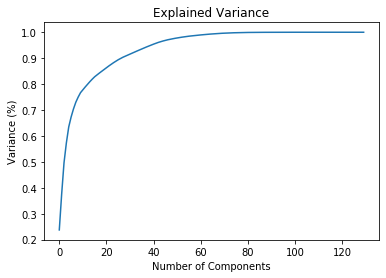

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
principalComponents = pca.fit_transform(scaled_data_final)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

From the diagram above, it can be seen that 50 principal components explain almost 90% of the variance in data and 60 principal components explain around 95% of the variance in data.

So, instead of giving all the columns as input, we’d only feed these 50 principal components of the data to the machine learning algorithm and we’d obtain a similar result.

In [ ]:
pca = PCA(n_components=50)
new_data = pca.fit_transform(scaled_data_final)
# This will be the new data fed to the algorithm.
principal_Df = pd.DataFrame(data = new_data
             , columns = ['pc1','pc2','pc3','pc4','pc5','pc6','pc7','pc8','pc9','pc10',
                          'pc11','pc12','pc13','pc14','pc15','pc16','pc17','pc18','pc19','pc20',
                          'pc21','pc22','pc23','pc24','pc25','pc26','pc27','pc28','pc29','pc30',
                         'pc31','pc32','pc33','pc34','pc35','pc36','pc37','pc38','pc39','pc40',
                         'pc41','pc42','pc43','pc44','pc45','pc46','pc47','pc48','pc49','pc50'])

In [ ]:
principal_Df.describe()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50
count,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05
mean,-2.190298e-16,-6.432492e-17,1.912857e-16,-4.154520e-16,-6.004097e-16,5.777521e-16,4.138180e-16,8.588466e-16,-5.008539e-18,1.036361e-16,1.083112e-16,-3.252064e-16,-1.702347e-16,1.725038e-16,5.089709e-16,-5.924488e-16,1.681337e-16,-3.255583e-16,-1.446125e-16,-7.487479e-17,9.493100e-18,1.646580e-16,3.193944e-16,4.916414e-16,3.931676e-17,-6.217724e-17,1.400744e-16,9.294233e-17,3.315220e-16,-1.162492e-17,1.828388e-16,2.999677e-16,-1.599440e-17,3.007471e-16,4.375917e-17,5.216120e-18,-1.074016e-16,1.191955e-16,-1.348079e-16,2.112195e-16,2.547693e-16,-1.048712e-16,1.898179e-16,2.063768e-16,5.043883e-16,3.375597e-16,-5.128462e-18,-1.410522e-17,1.788074e-16,-1.352202e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,1.772871e+00,1.263038e+00,1.104436e+00,8.829216e-01,7.351711e-01,5.635156e-01,5.759277e-01,3.653092e-01,4.692711e-01,4.269045e-01,2.297829e-02,3.449163e-01,1.594632e-01,3.386415e-01,2.982340e-01,2.233654e-01,2.257298e-01,-2.812100e-02,6.204864e-02,1.236566e-01,1.673153e-01,-4.042804e-03,2.113711e-01,2.336282e-01,-7.833179e-02,1.770805e-01,2.133944e-01,1.944717e-01,-9.113436e-03,-1.196199e-02,4.135672e-02,5.830922e-02,5.540081e-02,1.384707e-01,9.324284e-02,1.665987e-01,3.754768e-02,8.694393e-03,2.572404e-02,8.310614e-02,1.609312e-01,-4.752928e-02,1.495356e-01,1.104628e-01,1.049051e-01,1.157712e-01,8.403183e-02,8.877626e-02,9.466719e-02,6.338180e-02
max,7.618355e+00,6.715714e+00,7.210785e+00,7.213519e+00,6.456656e+00,6.590527e+00,2.753115e+00,5.552766e+00,2.842008e+00,2.073999e+00,9.542639e-01,1.376634e+00,1.281374e+00,2.265681e+00,2.935252e+00,3.431589e+00,2.871521e+00,9.572428e-01,8.243254e-01,1.003132e+00,9.418968e-01,1.029585e+00,2.127028e+00,1.767664e+00,1.080564e+00,2.516099e+00,1.425981e+00,1.590351e+00,1.152984e+00,1.065715e+00,1.170255e+00,1.420758e+00,1.319293e+00,1.792787e+00,1.262544e+00,7.242679e-01,1.009420e+00,1.082816e+00,1.335605e+00,1.586648e+00,1.943862e+00,1.081362e+00,1.606849e+00,1.665873e+00,1.882008e+00,1.312198e+00,1.114992e+00,9.158158e-01,8.409202e-01,7.264857e-01


In [ ]:
#principal_Df['DEP_DELAY']=base_dummied['DEP_DELAY']

In [ ]:
principal_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 639598 entries, 0 to 639597
Data columns (total 50 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   pc1     639598 non-null  float64
 1   pc2     639598 non-null  float64
 2   pc3     639598 non-null  float64
 3   pc4     639598 non-null  float64
 4   pc5     639598 non-null  float64
 5   pc6     639598 non-null  float64
 6   pc7     639598 non-null  float64
 7   pc8     639598 non-null  float64
 8   pc9     639598 non-null  float64
 9   pc10    639598 non-null  float64
 10  pc11    639598 non-null  float64
 11  pc12    639598 non-null  float64
 12  pc13    639598 non-null  float64
 13  pc14    639598 non-null  float64
 14  pc15    639598 non-null  float64
 15  pc16    639598 non-null  float64
 16  pc17    639598 non-null  float64
 17  pc18    639598 non-null  float64
 18  pc19    639598 non-null  float64
 19  pc20    639598 non-null  float64
 20  pc21    639598 non-null  float64
 21  pc22    63

In [ ]:
principal_Df.describe()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50
count,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05,6.395980e+05
mean,-2.190298e-16,-6.432492e-17,1.912857e-16,-4.154520e-16,-6.004097e-16,5.777521e-16,4.138180e-16,8.588466e-16,-5.008539e-18,1.036361e-16,1.083112e-16,-3.252064e-16,-1.702347e-16,1.725038e-16,5.089709e-16,-5.924488e-16,1.681337e-16,-3.255583e-16,-1.446125e-16,-7.487479e-17,9.493100e-18,1.646580e-16,3.193944e-16,4.916414e-16,3.931676e-17,-6.217724e-17,1.400744e-16,9.294233e-17,3.315220e-16,-1.162492e-17,1.828388e-16,2.999677e-16,-1.599440e-17,3.007471e-16,4.375917e-17,5.216120e-18,-1.074016e-16,1.191955e-16,-1.348079e-16,2.112195e-16,2.547693e-16,-1.048712e-16,1.898179e-16,2.063768e-16,5.043883e-16,3.375597e-16,-5.128462e-18,-1.410522e-17,1.788074e-16,-1.352202e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75%,1.772871e+00,1.263038e+00,1.104436e+00,8.829216e-01,7.351711e-01,5.635156e-01,5.759277e-01,3.653092e-01,4.692711e-01,4.269045e-01,2.297829e-02,3.449163e-01,1.594632e-01,3.386415e-01,2.982340e-01,2.233654e-01,2.257298e-01,-2.812100e-02,6.204864e-02,1.236566e-01,1.673153e-01,-4.042804e-03,2.113711e-01,2.336282e-01,-7.833179e-02,1.770805e-01,2.133944e-01,1.944717e-01,-9.113436e-03,-1.196199e-02,4.135672e-02,5.830922e-02,5.540081e-02,1.384707e-01,9.324284e-02,1.665987e-01,3.754768e-02,8.694393e-03,2.572404e-02,8.310614e-02,1.609312e-01,-4.752928e-02,1.495356e-01,1.104628e-01,1.049051e-01,1.157712e-01,8.403183e-02,8.877626e-02,9.466719e-02,6.338180e-02
max,7.618355e+00,6.715714e+00,7.210785e+00,7.213519e+00,6.456656e+00,6.590527e+00,2.753115e+00,5.552766e+00,2.842008e+00,2.073999e+00,9.542639e-01,1.376634e+00,1.281374e+00,2.265681e+00,2.935252e+00,3.431589e+00,2.871521e+00,9.572428e-01,8.243254e-01,1.003132e+00,9.418968e-01,1.029585e+00,2.127028e+00,1.767664e+00,1.080564e+00,2.516099e+00,1.425981e+00,1.590351e+00,1.152984e+00,1.065715e+00,1.170255e+00,1.420758e+00,1.319293e+00,1.792787e+00,1.262544e+00,7.242679e-01,1.009420e+00,1.082816e+00,1.335605e+00,1.586648e+00,1.943862e+00,1.081362e+00,1.606849e+00,1.665873e+00,1.882008e+00,1.312198e+00,1.114992e+00,9.158158e-01,8.409202e-01,7.264857e-01


# REGRESSION MODEL ON PCA DATA

In [ ]:
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm

In [ ]:
base_dummied_regression_Y.shape

(639598,)

In [ ]:
principal_Df.shape

(639598, 50)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x=principal_Df
y=base_dummied_regression_Y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=4)

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred=regr.predict(x_test)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import math

In [ ]:
MAE=mean_absolute_error(y_test, y_pred)
MAE

21.44211209988017

In [ ]:
MSE=mean_squared_error(y_test, y_pred)
MSE

2286.6331187145047

In [ ]:
RMSE=math.sqrt(MSE)
RMSE

47.81875279338122

In [ ]:
R2=r2_score(y_test, y_pred)
R2

0.01962625350140823

In [ ]:
regr.score(x_test, y_test)

0.01962625350140823

In [ ]:
regr.score(x_train, y_train)

0.018126982272211767

# RANDOM FOREST MODEL ON PCA DATA


In [ ]:
def create_categories(y):
    if y<15 :
        return "NO DELAY"
    else:
        if y<20:
            return "15MIN"
        else:
            if y<35:
                return "30MIN"
            else:
                if y<50:
                    return "45MIN"
                else:
                    return "60MIN"
    

In [ ]:
create_categories(19)

'15MIN'

In [ ]:
y_new=y.apply(create_categories)

In [ ]:
type(y_new)

pandas.core.series.Series

In [ ]:
y_new=pd.DataFrame(y_new)
y_new["Count"]=1
y_new

,DEP_DELAY,Count
0,NO DELAY,1
1,NO DELAY,1
...,...,...
639596,NO DELAY,1
639597,NO DELAY,1


In [ ]:
y_new.groupby(by="DEP_DELAY")["Count"].count()

DEP_DELAY
15MIN        17061
30MIN        32105
45MIN        18482
60MIN        50862
NO DELAY    521088
Name: Count, dtype: int64

In [ ]:
y_new.drop(columns=["Count"],inplace=True)
y_new

,DEP_DELAY
0,NO DELAY
1,NO DELAY
...,...
639596,NO DELAY
639597,NO DELAY


In [ ]:
x

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50
0,-1.773716,2.238500,-0.995633,0.296085,-1.480742,-0.657127,0.413595,-0.464232,-0.158307,-0.904686,-0.042751,0.096181,-0.088993,0.065702,-0.028665,-0.317157,-0.236606,-0.249945,0.006952,0.700760,-0.405459,-0.075736,0.759930,-0.216455,-0.182779,0.099691,0.366491,0.005255,0.050969,0.002254,-0.002680,0.167827,-0.036663,0.294544,0.134475,0.357830,0.659249,-0.172358,-0.525888,0.542936,-0.558239,-0.057882,-0.492572,-0.371539,-0.134548,-0.262328,0.099310,0.288626,0.254890,0.575592
1,1.742798,-1.159862,0.686157,-0.861655,-0.800525,0.454718,-0.260086,0.389906,0.654512,-0.284492,-0.226205,0.438195,-0.002704,-0.718020,0.470906,-0.304610,-0.202464,0.030700,-0.010961,-0.008342,0.033743,0.076463,-0.111903,-0.165959,0.984675,-0.038230,0.074614,-0.125581,-0.107803,-0.051200,-0.021730,-0.084341,0.041455,-0.013053,0.085538,0.615376,-0.524963,-0.346034,-0.086761,-0.113286,-0.007397,-0.086439,-0.016338,-0.054358,0.029193,0.096694,0.002390,-0.010407,-0.036045,-0.029569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639596,1.077383,-1.545055,0.438501,-1.956786,-1.112771,-0.611234,-0.639604,0.232556,0.773716,-0.236271,0.872015,-0.237642,-0.047664,-0.198232,0.071532,-0.102461,-0.055816,-0.376541,-0.628945,-0.450877,-0.172921,-0.194901,-0.195616,0.105190,-0.147485,-0.068619,0.032517,0.147650,-0.062980,-0.352717,0.849337,-0.023871,0.035051,-0.122768,0.171538,-0.207377,-0.042276,-0.035680,-0.018579,0.058021,0.218197,-0.054424,0.131050,0.010053,-0.045157,0.009280,-0.008992,0.031084,0.005697,-0.068455
639597,-3.076786,-0.539633,-0.437321,0.045755,0.860785,-0.535148,-1.347055,0.190473,-0.069618,-1.196927,-0.263019,0.689357,-0.194019,-0.338781,-0.018657,-0.134741,-0.036071,0.907790,-0.173082,-0.050913,-0.110506,-0.057333,-0.046848,0.027098,-0.053688,0.105331,0.135569,-0.250202,-0.065652,-0.004528,0.047239,0.092702,0.134393,0.183126,0.110742,0.625752,-0.535632,-0.336689,-0.094657,-0.103962,0.056141,-0.092989,0.090142,-0.123443,0.006886,-0.190497,0.052298,0.268767,0.254574,0.575918


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_new, test_size=0.2, random_state=4,stratify=y_new)

In [ ]:
rf = RandomForestClassifier(n_estimators=30, max_depth=15, random_state=123, n_jobs=-1)
rf.fit(x_train, y_train)

C:\Users\P2190101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

Text(0.5, 0, 'Feature Importance')

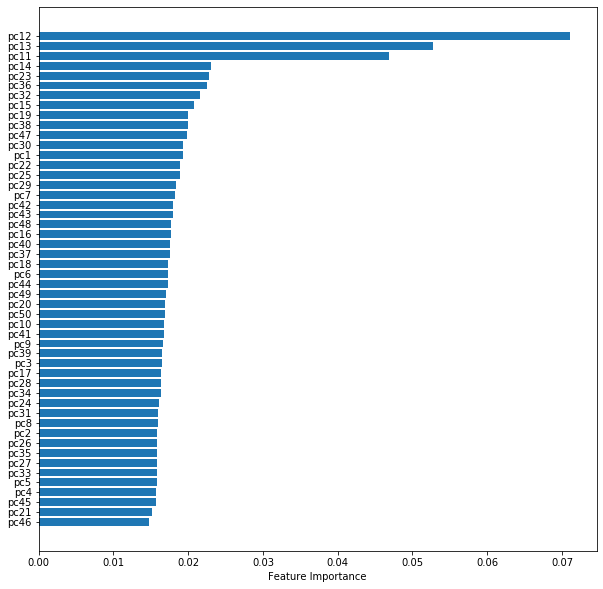

In [ ]:
# Gini importance
sorted_index = rf.feature_importances_.argsort()
plt.figure(figsize=[10,10])
plt.barh(x_train.columns[sorted_index].tolist()[:], rf.feature_importances_[sorted_index][:])
plt.xlabel("Feature Importance")

In [ ]:
y_pred_rf=rf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
rf_accuracy=accuracy_score(y_test, y_pred_rf)
rf_accuracy

0.8146888680425266

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_test, y_pred_rf, average='macro')

0.17965631253686973

In [ ]:
f1_score(y_test, y_pred_rf, average='micro')

0.8146888680425266

In [ ]:
f1_score(y_test, y_pred_rf, average='weighted')

0.7315522098241383

In [ ]:
f1_score(y_test, y_pred_rf, average=None)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.92888714e-04,
       8.97888674e-01])

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
y_pred_proba=rf.predict_proba(x_test)
y_pred_proba

array([[0.02604244, 0.05030978, 0.03172356, 0.09235922, 0.799565  ],
       [0.04879139, 0.0226382 , 0.01453453, 0.0375023 , 0.87653359],
       [0.04360678, 0.07023557, 0.0368268 , 0.08316357, 0.76616729],
       ...,
       [0.02771871, 0.05518072, 0.03306003, 0.10552407, 0.77851647],
       [0.02814915, 0.03915019, 0.02372113, 0.0640602 , 0.84491933],
       [0.02398479, 0.05292292, 0.03013261, 0.06914344, 0.82381624]])

In [ ]:
y_test_new=pd.get_dummies(y_test)
y_test_new

,DEP_DELAY_15MIN,DEP_DELAY_30MIN,DEP_DELAY_45MIN,DEP_DELAY_60MIN,DEP_DELAY_NO DELAY
423351,0,0,0,1,0
565317,0,0,0,0,1
...,...,...,...,...,...
144132,0,0,0,0,1
308063,0,0,0,0,1


In [ ]:
roc_auc_score(y_test_new, rf.predict_proba(x_test))

0.644510329635065

In [ ]:
from sklearn.metrics import roc_curve, auc

y_score_rf = y_pred_proba
n_classes_rf = y_test_new.shape[1]
n_classes_rf

5

In [ ]:
y_score_rf

array([[0.02604244, 0.05030978, 0.03172356, 0.09235922, 0.799565  ],
       [0.04879139, 0.0226382 , 0.01453453, 0.0375023 , 0.87653359],
       [0.04360678, 0.07023557, 0.0368268 , 0.08316357, 0.76616729],
       ...,
       [0.02771871, 0.05518072, 0.03306003, 0.10552407, 0.77851647],
       [0.02814915, 0.03915019, 0.02372113, 0.0640602 , 0.84491933],
       [0.02398479, 0.05292292, 0.03013261, 0.06914344, 0.82381624]])

In [ ]:
y_test_new1=np.asarray(y_test_new)
y_test_new1

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]], dtype=uint8)

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_rf):
    fpr[i], tpr[i], _ = roc_curve(y_test_new1[:, i], y_score_rf[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new1.ravel(), y_score_rf.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

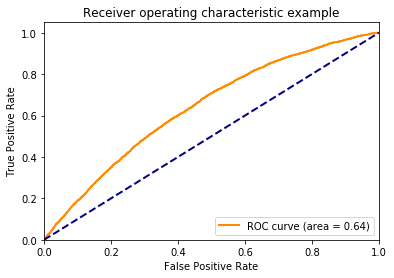

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Logistic Regression

In [ ]:
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression


In [ ]:
lgr = LogisticRegression(random_state=0).fit(x_train, y_train)
lgr.predict(x_test)

#clf.predict_proba()

#clf.score(x, y)

C:\Users\P2190101\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['NO DELAY', 'NO DELAY', 'NO DELAY', ..., 'NO DELAY', 'NO DELAY',
       'NO DELAY'], dtype=object)

In [ ]:
y_pred_proba_lgr=clf.predict_proba(x_test)
y_pred_proba_lgr

array([[0.02807066, 0.05955347, 0.04448031, 0.14858987, 0.7193057 ],
       [0.01597591, 0.0269601 , 0.01242116, 0.03882776, 0.90581507],
       [0.04593048, 0.07720664, 0.03810092, 0.0717797 , 0.76698227],
       ...,
       [0.0270926 , 0.04892705, 0.03051183, 0.10223006, 0.79123846],
       [0.02426904, 0.04415851, 0.026707  , 0.07673824, 0.82812721],
       [0.03219504, 0.06035263, 0.03035185, 0.05914844, 0.81795205]])

In [ ]:
y_score_lgr = y_pred_proba_clf
n_classes_lgr = y_test_new.shape[1]
n_classes_lgr

5

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_lgr):
    fpr[i], tpr[i], _ = roc_curve(y_test_new1[:, i], y_score_lgr[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new1.ravel(), y_score_lgr.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

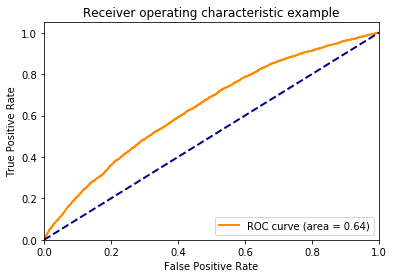

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# ENSEMBLE OF RF and LG

In [ ]:
y_score_lgr

array([[0.02807066, 0.05955347, 0.04448031, 0.14858987, 0.7193057 ],
       [0.01597591, 0.0269601 , 0.01242116, 0.03882776, 0.90581507],
       [0.04593048, 0.07720664, 0.03810092, 0.0717797 , 0.76698227],
       ...,
       [0.0270926 , 0.04892705, 0.03051183, 0.10223006, 0.79123846],
       [0.02426904, 0.04415851, 0.026707  , 0.07673824, 0.82812721],
       [0.03219504, 0.06035263, 0.03035185, 0.05914844, 0.81795205]])

In [ ]:
y_score_rf

array([[0.02604244, 0.05030978, 0.03172356, 0.09235922, 0.799565  ],
       [0.04879139, 0.0226382 , 0.01453453, 0.0375023 , 0.87653359],
       [0.04360678, 0.07023557, 0.0368268 , 0.08316357, 0.76616729],
       ...,
       [0.02771871, 0.05518072, 0.03306003, 0.10552407, 0.77851647],
       [0.02814915, 0.03915019, 0.02372113, 0.0640602 , 0.84491933],
       [0.02398479, 0.05292292, 0.03013261, 0.06914344, 0.82381624]])

In [ ]:
y_score_ensemble=(y_score_lgr + y_score_rf)/2
y_score_ensemble

array([[0.02705655, 0.05493162, 0.03810194, 0.12047454, 0.75943535],
       [0.03238365, 0.02479915, 0.01347784, 0.03816503, 0.89117433],
       [0.04476863, 0.0737211 , 0.03746386, 0.07747163, 0.76657478],
       ...,
       [0.02740566, 0.05205389, 0.03178593, 0.10387707, 0.78487746],
       [0.0262091 , 0.04165435, 0.02521406, 0.07039922, 0.83652327],
       [0.02808991, 0.05663777, 0.03024223, 0.06414594, 0.82088414]])

In [ ]:
n_classes_ens= y_test_new.shape[1]
n_classes_ens

5

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes_lgr):
    fpr[i], tpr[i], _ = roc_curve(y_test_new1[:, i], y_score_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_new1.ravel(), y_score_ensemble.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

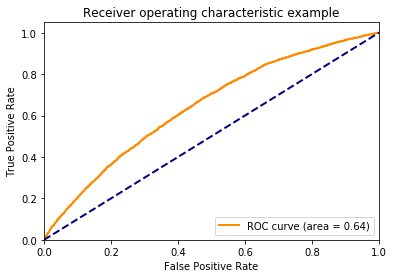

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# NEURAL NETWORK

In [ ]:
!pip install tensorflow

You should consider upgrading via the 'C:\Users\P2190101\AppData\Local\Continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
import tensorflow as tf

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
x_train.shape

(511678, 50)

In [ ]:
import tensorflow as tf

# Prepare data.
#(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#x_train, x_test = x_train / 255.0, x_test / 255.0

# Create a base model -- sequential, functional, or subclass.
model = tf.keras.Sequential([
    tf.keras.Input((511678, 50), name='feature'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

# Compile, train, and evaluate.
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
model.fit({'feature': x_train, 'label': y_train}, batch_size=32, epochs=5)
model.evaluate({'feature': x_test, 'label': y_test})

ResourceExhaustedError: OOM when allocating tensor with shape[25583900,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu [Op:Mul] name: dense_2/kernel/Initializer/random_uniform/mul/